# Volatility Forecasting using Temporal Convolutional Networks and ARCH family models

*Divya Patel, Joaquin Garay, and Roger Li*

NYU Tandon Ms Financial Engineering Students

Fall 2024



## 1. Data Preprocessing

Import packages.

In [ ]:
DJIA_SPLIT_DATE = '2007-12-31'
NDX_SPLIT_DATE = '2016-12-31'

In [ ]:
import zipfile
import os
!pip install wget
import wget

import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

!pip install scipy
from scipy.optimize import minimize

!pip install arch
from arch.univariate import EWMAVariance


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=4a5cfd1f63afaa2b83a3bc54c1acc83d6db9c38b41360ffecc144cd24b04b845
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 30.0 MB/s eta 0:00:00


Download data

In [ ]:
filename = wget.download('https://github.com/alessiopetrozziello/Deep-Learning-for-Volatility-Forecasting/archive/refs/tags/v1.0.zip')

Unzip file

In [ ]:
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('./')

with zipfile.ZipFile('/content/Deep-Learning-for-Volatility-Forecasting-1.0/DJI 500.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
with zipfile.ZipFile('/content/Deep-Learning-for-Volatility-Forecasting-1.0/NASDAQ 100.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

Load and read the data files.

*   NASDAQ 100 Dataset:
  *   From 2012-12-03 to 2017-11-28 (both inclusive)
  *   1257 Observations.
  *   We manually scale the data. Returns $\cdot 100$, Realized Measure $\cdot 100^2$
*   DJIA Dataset:
  *   From 2002-01-02 to 2008-08-29 (both inclusive)
  *   1663 Observations.
  *   Some stocks have less obs. (e.g. GM has only 1640 obs (until 2008-07-30) )
  * In this case, the data is already scaled.

Note that dates are slightly different of what's written on Petrozziello (2022) because of weekends and holidays.

In [ ]:
# import random module for randomly selecting 20 stocks.

import random
random.seed(42)

In [ ]:
# read and load the NASDAQ100 files as dataframes:
# NDX: list of dataframes for each asset, containing the column of open-close return and the realized measure.

NDX_ret_df = pd.read_csv('/content/NASDAQ 100/returns.txt', sep='\t')
NDX_vol_df = pd.read_csv('/content/NASDAQ 100/volatility.txt', sep='\t')

# Add the dates to the index
yfinance_df = yf.download('AAPL', start='2012-12-01', end='2017-11-29')
yfinance_df.index = yfinance_df.index.tz_localize(None)
NDX_ret_df.index = yfinance_df.index
NDX_vol_df.index = yfinance_df.index

# randomly select just 20.
selected_columns = random.sample(list(NDX_ret_df.columns), 20)
selected_columns[0] = 'AAPL'    # retain AAPL
print(selected_columns)
NDX_ret_df, NDX_vol_df = NDX_ret_df[selected_columns], NDX_vol_df[selected_columns]

NDX_tickers = NDX_ret_df.columns
NDX = {}

for col in NDX_tickers:
    NDX[col] = pd.DataFrame({
        "Ret": NDX_ret_df[col]*100, #Open-to-close return
        "RM": np.maximum(NDX_vol_df[col]*100*100, 0.01)   #Realized Measure
    })
    quantile = NDX[col]["RM"].quantile(0.99)
    NDX[col]["RM"] = NDX[col]["RM"].apply(lambda x: min(x, quantile))


# Check for missing values in each DataFrame within the NDX dictionary
missing_values = {key: df.isna().any().any() for key, df in NDX.items()}

# Print results
for key, has_missing in missing_values.items():
    if has_missing:
        print(f"{key} has missing values")

[*********************100%***********************]  1 of 1 completed

['AAPL', 'BIIB', 'ADP', 'FAST', 'EA', 'DISCK', 'CERN', 'BIDU', 'VOD', 'PAYX', 'ATVI', 'SBUX', 'LBTYK', 'ADSK', 'DISCA', 'DISH', 'MYL', 'SIRI', 'PCLN', 'CTSH']


In [ ]:
print("Amount of data below 0.01 min threshold")
for col in NDX.keys():
  print(f" {col}: {(NDX[col]['RM'] == 0.01).sum()}")


Amount of data below 0.01 min threshold
 AAPL: 59
 BIIB: 26
 ADP: 78
 FAST: 36
 EA: 30
 DISCK: 44
 CERN: 36
 BIDU: 28
 VOD: 124
 PAYX: 47
 ATVI: 27
 SBUX: 51
 LBTYK: 46
 ADSK: 43
 DISCA: 35
 DISH: 35
 MYL: 43
 SIRI: 24
 PCLN: 52
 CTSH: 53


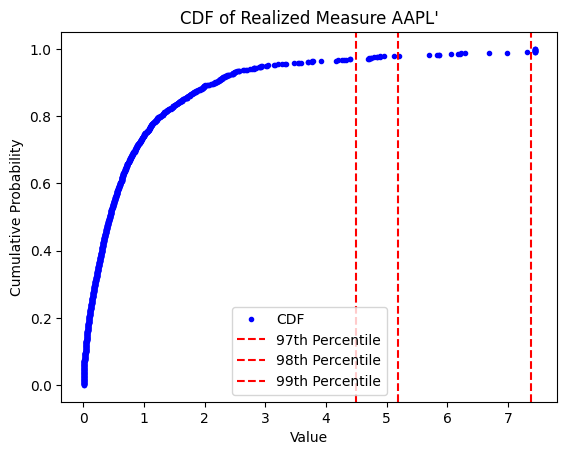

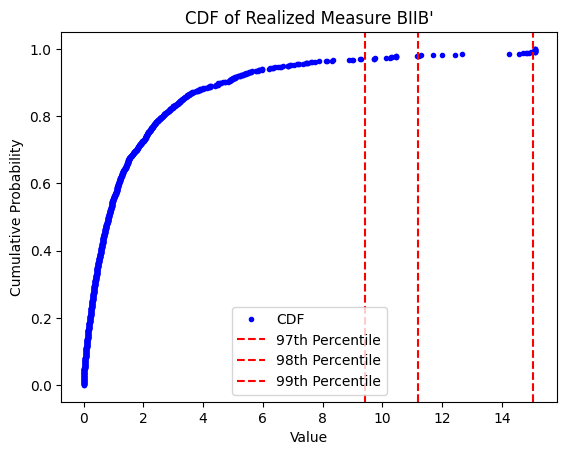

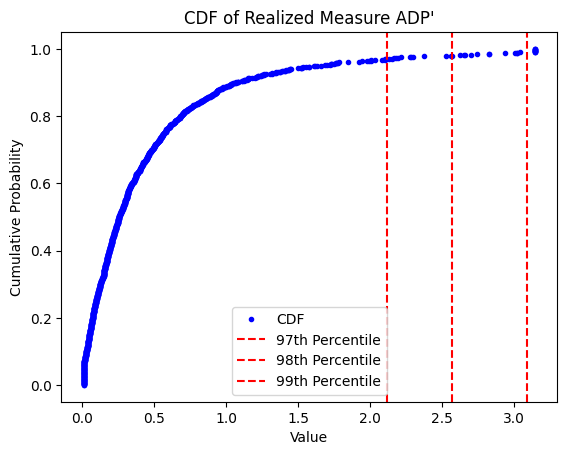

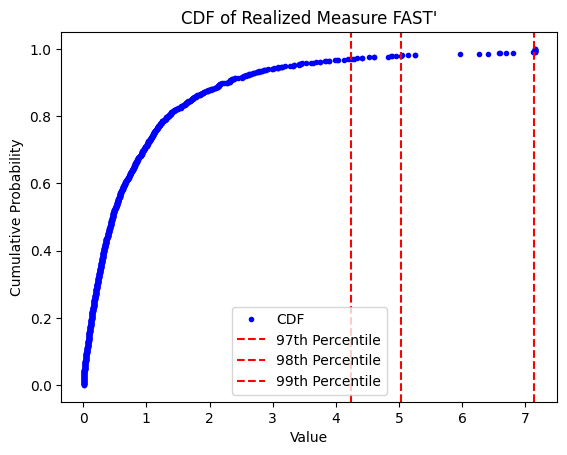

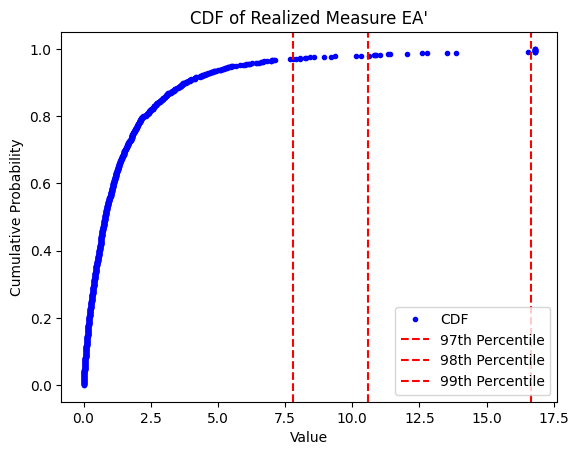

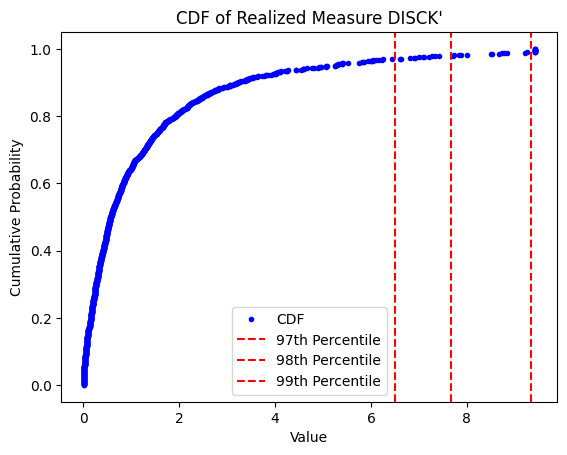

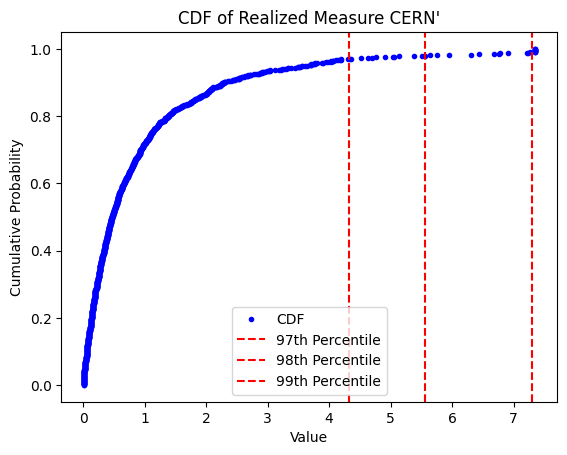

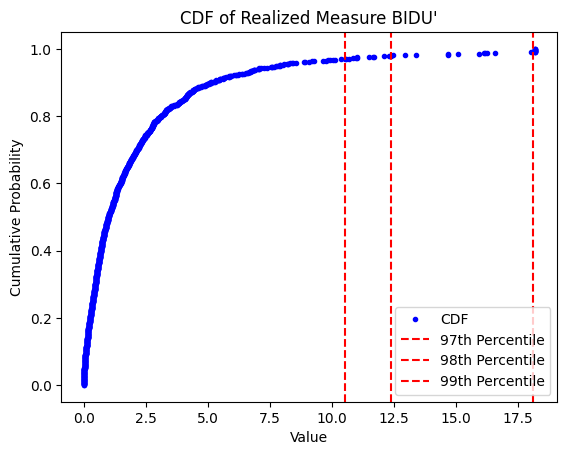

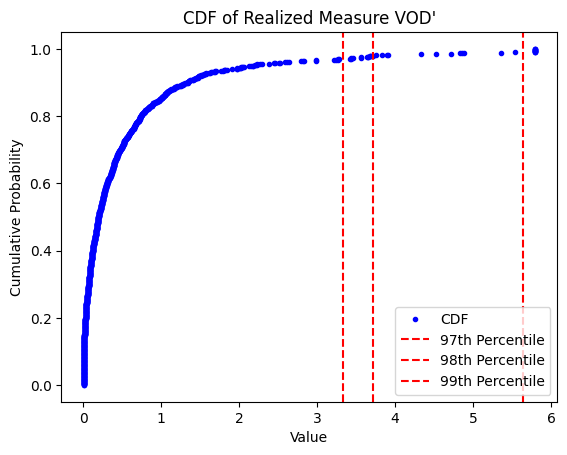

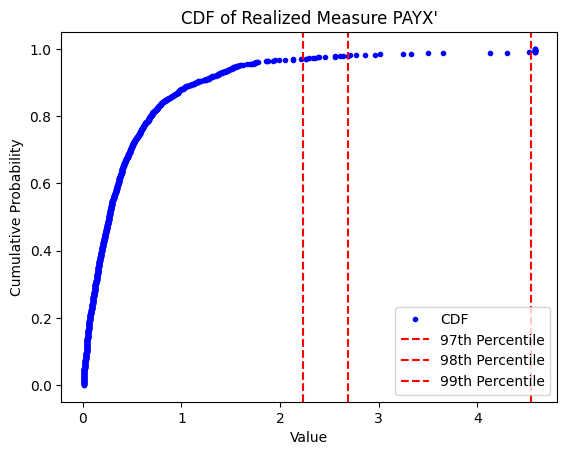

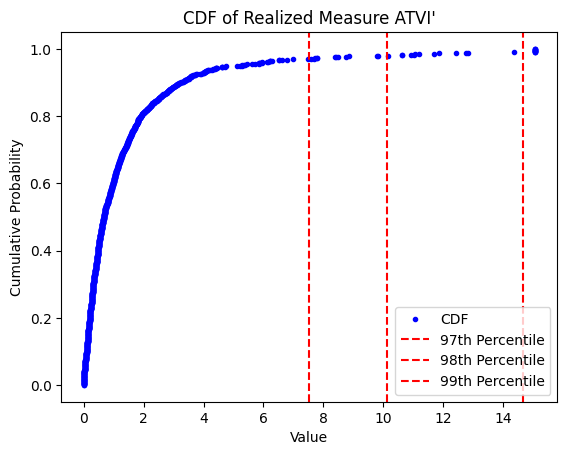

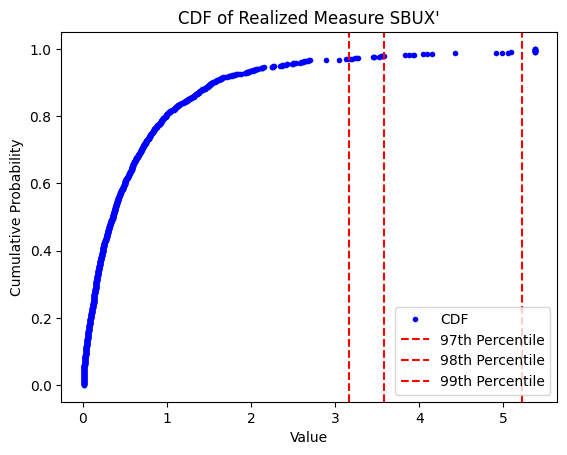

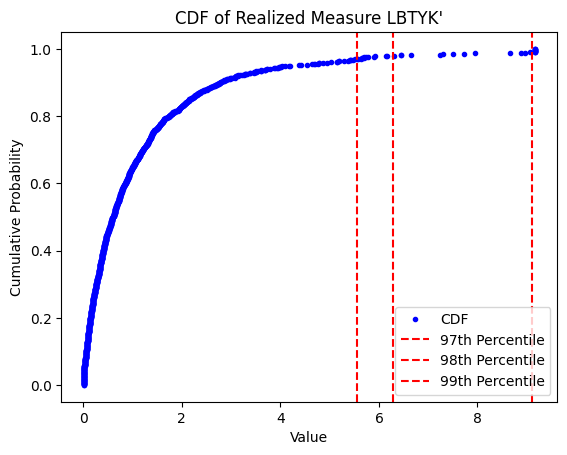

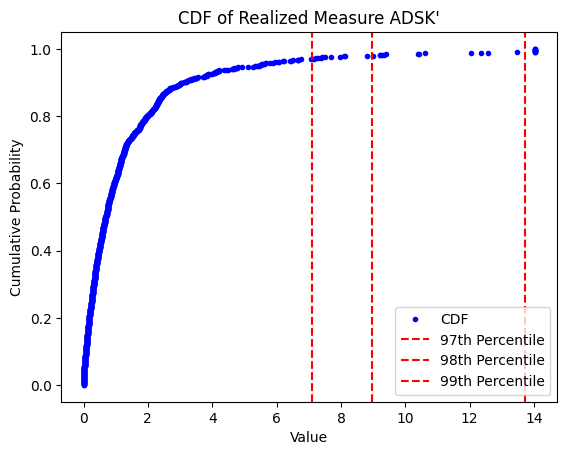

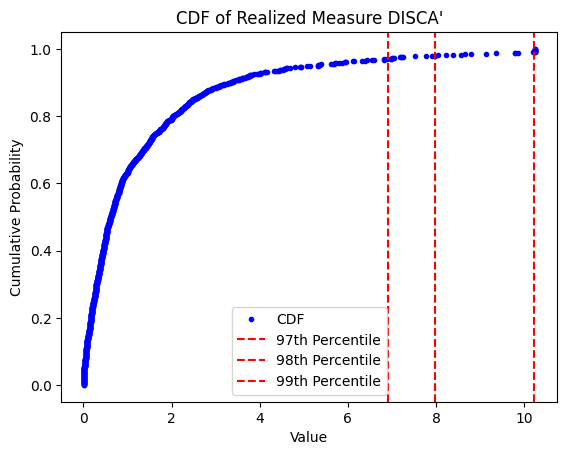

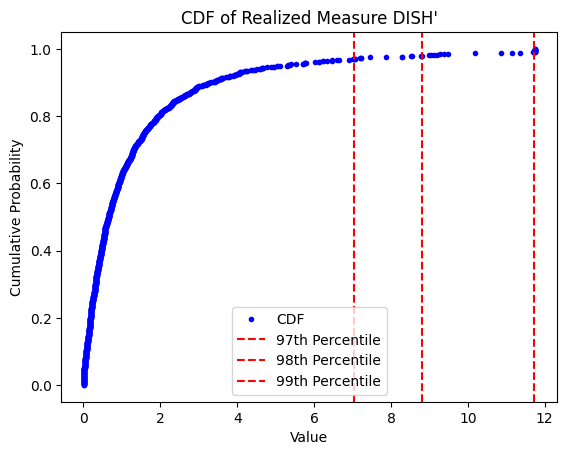

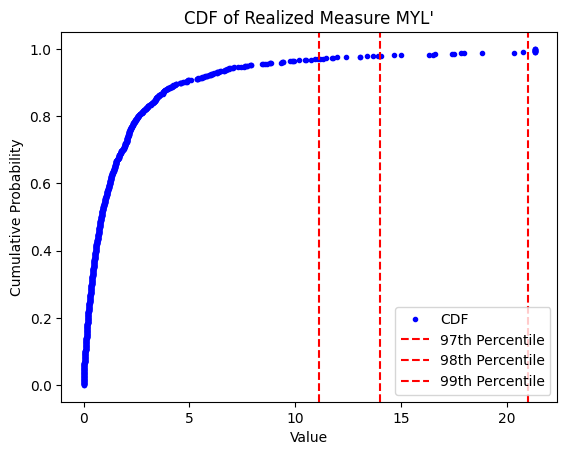

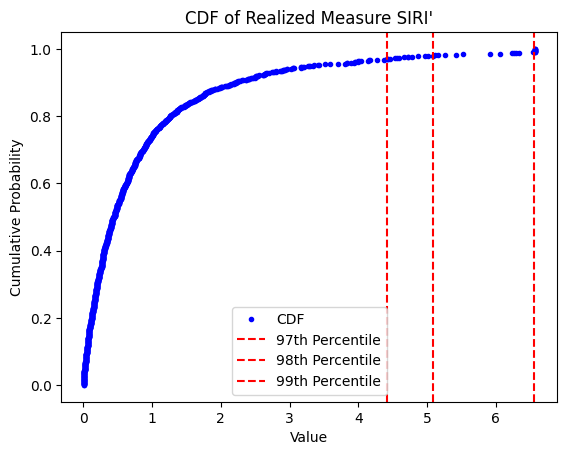

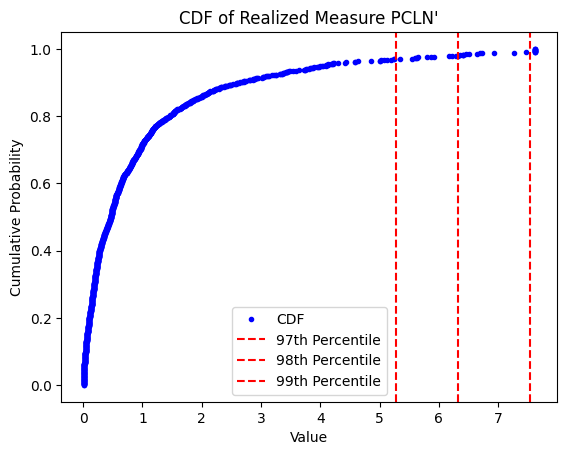

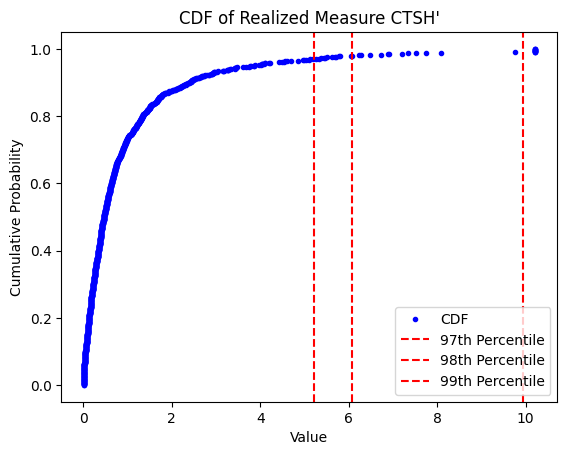

In [ ]:
for col in NDX.keys():
    data = np.sort(NDX[col]['RM'])  # Sort data for CDF plot
    cdf = np.arange(1, len(data) + 1) / len(data)  # Compute CDF values

    # Plot the CDF
    plt.figure()
    plt.plot(data, cdf, marker='.', linestyle='none', color='blue', label='CDF')

    plt.axvline(np.percentile(data, 97), color='red', linestyle='--', label='97th Percentile')  # Add vertical line at 98th percentile
    plt.axvline(np.percentile(data, 98), color='red', linestyle='--', label='98th Percentile')  # Add vertical line at 98th percentile
    plt.axvline(np.percentile(data, 99), color='red', linestyle='--', label='99th Percentile')  # Add vertical line at 98th percentile

    # Add labels and legend
    plt.xlabel('Value')
    plt.ylabel('Cumulative Probability')
    plt.title(f"CDF of Realized Measure {col}'")
    plt.legend()
    plt.show()



In [ ]:
print("Amount of data above 3 standard deviations")
for col in NDX.keys():
  print(f" {col}: {NDX[col]['RM'][NDX[col]['RM'] > NDX[col]['RM'].mean() + 3*NDX[col]['RM'].std()]}")

Amount of data above 3 standard deviations
 AAPL: Date
2012-12-07    7.439231
2012-12-11    4.701160
2012-12-18    7.315876
2012-12-31    4.694342
2013-01-02    7.439231
2013-01-16    4.747903
2013-01-24    7.439231
2013-01-29    5.117056
2013-02-06    4.950809
2013-02-08    4.845263
2013-04-25    4.883961
2013-04-29    6.284090
2013-04-30    5.834180
2013-07-01    5.867583
2013-07-24    6.218122
2013-08-13    7.439231
2013-08-14    7.439231
2013-09-23    6.687453
2014-01-28    5.861338
2014-04-24    7.439231
2014-04-28    5.197552
2014-12-18    4.893466
2015-01-28    7.439231
2015-08-13    6.168591
2015-08-25    7.439231
2015-08-26    6.200380
2015-08-27    7.439231
2016-01-22    7.439231
2016-01-29    4.700650
2016-04-27    4.740975
2016-07-27    7.439231
2016-09-13    6.066197
2016-09-14    4.791506
2016-09-15    6.987813
2017-02-01    7.439231
2017-08-02    7.439231
2017-10-30    5.689890
2017-11-03    4.840121
Name: RM, dtype: float64
 BIIB: Date
2013-01-28    11.683259
2013-03-28

In [ ]:
# read and load the DJIA files

# Each asset is represented by three different time series:
  # The DJIA csv are labeled with "Var1", "Var2", "Var3", and "Var4".
  # - Var1: Date
  # - Var2: Open-Close daily returns (scaled to %)
  # - Var3: Realized Volatility:
  # - Var4: Close-to-Close Returns.


DJIA = {}

for filename in os.listdir('/content/DJI 500'):
  ticker = filename.split('.')[0]
  df = pd.DataFrame(pd.read_csv('/content/DJI 500/'+filename))
  df['date'] = pd.to_datetime(df['Var1'], format='%Y%m%d')
  df = df.drop('Var1', axis=1)
  df.set_index('date', inplace=True)
  df.index = df.index.normalize()
  df.rename(columns={'Var2': 'Ret', 'Var3': 'RM', 'Var4': 'Close_Ret'}, inplace=True)
  df = df.drop(columns=df.columns[0]) #Drop first column which is an index
  DJIA[ticker] = df

# ramdomly select 20 DJIA stocks
# selected_columns = random.sample(list(DJIA.keys()), 20)
# print(selected_columns)
selected_columns = ['XOM', 'INTC', 'T', 'BAC', 'PG', 'SPY', 'AXP', 'MMM', 'DD', 'IBM', 'CAT', 'MRK', 'GE', 'GM', 'AA', 'JNJ', 'DIS', 'CVX', 'HD', 'KO']
print(len(selected_columns))
DJIA = {ticker: DJIA[ticker] for ticker in selected_columns}

# Check for missing values in each DataFrame within the DJIA dictionary
missing_values = {key: df.isna().any().any() for key, df in DJIA.items()}

# Print results
for key, has_missing in missing_values.items():
    if has_missing:
        print(f"{key} has missing values")

20


In [ ]:
for col in DJIA.keys():
  print(f"{col}:  {DJIA[col]['RM'].min():.4f}")

XOM:  0.1900
INTC:  0.4470
T:  0.1205
BAC:  0.1295
PG:  0.0421
SPY:  0.0579
AXP:  0.0686
MMM:  0.0847
DD:  0.2771
IBM:  0.1387
CAT:  0.2999
MRK:  0.1445
GE:  0.0765
GM:  0.2157
AA:  0.4928
JNJ:  0.0729
DIS:  0.2335
CVX:  0.2200
HD:  0.1755
KO:  0.0429


In [ ]:
print("NDX Apple Sample")
print(NDX["AAPL"].shape)
NDX["AAPL"].head()

NDX Apple Sample
(1257, 2)


Ret        RM
Date                          
2012-12-03  0.472516  0.696365
2012-12-04 -2.311667  0.070389
2012-12-05 -6.007856  0.044147
2012-12-06 -3.786671  1.227278
2012-12-07  2.145570  7.439231

In [ ]:
print("DJIA American Airlines Sample")
print(DJIA["AA"].shape)
DJIA["AA"].head()

DJIA American Airlines Sample
(1662, 3)


Ret        RM  Close_Ret
date                                     
2002-01-02 -0.783002  3.223669   0.168587
2002-01-03  0.582768  1.265373   1.449301
2002-01-04  1.378214  4.439617   3.052008
2002-01-07  0.580323  1.373043   2.019197
2002-01-08 -3.166491  5.618395  -1.911901

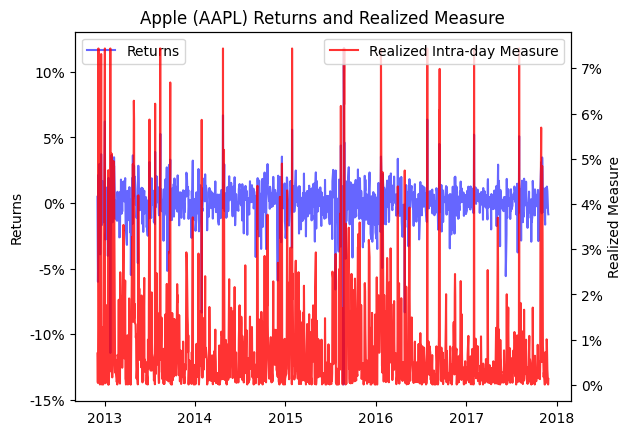

In [ ]:
# Custom formatter function to add the % symbol
def percent_formatter(x, pos):
    return f"{x:.0f}%"

fig, ax1 = plt.subplots()

# Plot Returns on primary y-axis
ax1.plot(NDX["AAPL"]["Ret"], label='Returns', color='blue', alpha=0.6)
ax1.set_ylabel('Returns')
ax1.yaxis.set_major_formatter(FuncFormatter(percent_formatter))  # Format with % symbol
ax1.legend(loc='upper left')
# Create a secondary y-axis for Realized Vol
ax2 = ax1.twinx()
ax2.plot(NDX["AAPL"]["RM"], label='Realized Intra-day Measure', color='red', alpha=0.8)
ax2.set_ylabel('Realized Measure')
ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))  # Format with % symbol
ax2.legend(loc='upper right')
plt.title('Apple (AAPL) Returns and Realized Measure')
plt.show()

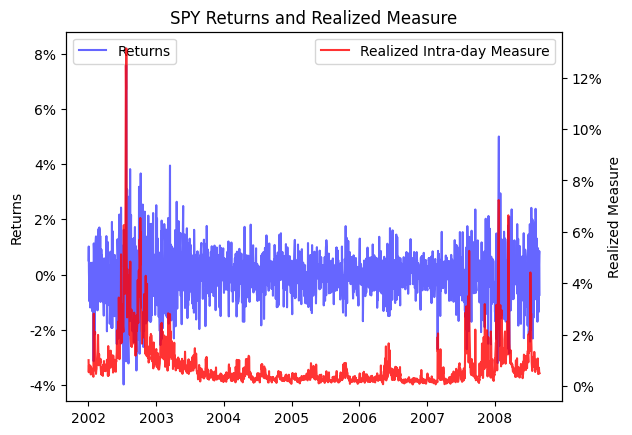

In [ ]:
fig, ax1 = plt.subplots()

# Plot Returns on primary y-axis
ax1.plot(DJIA["SPY"]["Ret"], label='Returns', color='blue', alpha=0.6)
ax1.set_ylabel('Returns')
ax1.yaxis.set_major_formatter(FuncFormatter(percent_formatter))  # Format with % symbol
ax1.legend(loc="upper left")

# Create a secondary y-axis for Realized Measure
ax2 = ax1.twinx()
ax2.plot(DJIA["SPY"]["RM"], label='Realized Intra-day Measure', color='red', alpha=0.8)
ax2.set_ylabel('Realized Measure')
ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))  # Format with % symbol
ax2.legend(loc="upper right")

plt.title('SPY Returns and Realized Measure')
plt.show()

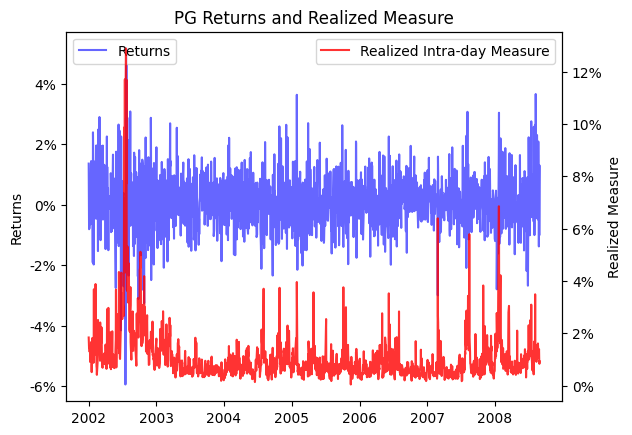

In [ ]:
fig, ax1 = plt.subplots()

# Plot Returns on primary y-axis
ax1.plot(DJIA["PG"]["Ret"], label='Returns', color='blue', alpha=0.6)
ax1.set_ylabel('Returns')
ax1.yaxis.set_major_formatter(FuncFormatter(percent_formatter))  # Format with % symbol
ax1.legend(loc="upper left")

# Create a secondary y-axis for Realized Measure
ax2 = ax1.twinx()
ax2.plot(DJIA["PG"]["RM"], label='Realized Intra-day Measure', color='red', alpha=0.8)
ax2.set_ylabel('Realized Measure')
ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))  # Format with % symbol
ax2.legend(loc="upper right")

plt.title('PG Returns and Realized Measure')
plt.show()

## 2. Realized GARCH Model

Since Petrozziello (2022) followed the same approach as Hansen (2012), we will focus on Hansen's setup and instructions for the implementation of our Realized GARCH model.

There are two possible versions:
*   Linear Realized GARCH
*   Log-linear Realized GARCH

The log-linear RealizedGARCH(p,q) reads:
$$r_t = \sqrt{h_t} \cdot z_t $$
$$\log h_t = \omega + \sum_{i=1}^p \beta_i \log h_{t-i} + \sum_{j=1}^q \gamma_j \log x_{t-j}$$
$$ \log x_t = \xi + \psi \log h_t + \tau(z_t) + u_t$$
where $u_t \sim N(0,\sigma^2_u)$ and $\tau(z_t)$ the so-called *leverage function*.

Hansen's choice for the leverage function the is a Hermite polynomial of second order $\tau(z_t) = \tau_1 z_t + \tau_2 (z_t^2 - 1)$, ensuring $E[\tau(z_t)] = 0$

### 2.1 Calibration Process

For calibration purposes, we aim to maximize the log-likelihood function. When adopting Gausian specifications, the log-likelihood function is given by

$$l(r,x;\theta ) = -\frac{1}{2} \sum_{t=1}^n \left[\log h_t + \frac{r_t^2}{h_t} + \log \sigma_u^2 + \frac{u_t^2}{\sigma_u^2} \right].$$

where $r$ and $x$ are our observable variable (i.e. return and realized measure) and $\theta$ the set of parameters to calibrate.

The process should follow the next schedule:
1.   Estimate an initial $h_0$
2.   Compute initial $z_0 = r_0 / \sqrt{h_0}$
3.   Compute initial $u_0 = \log x_0 - \xi - \psi \log h_0 - \tau_1 z_0 - \tau_2 (z_0^2 - 1)$
2.   For $t = 1$ to $N$, where $N$ is the training sample size:

  1. Compute $h_{t} = (h_{t-1})^\beta \cdot (x_{t-1})^\gamma \cdot e^\omega $
  2. Compute $z_t = r_t / \sqrt{h_t}$
  2. Compute $u_t = \log x_t - \xi - \psi \log h_t - \tau_1 z_t - \tau_2 (z_t^2 - 1)$
  4. Compute the log-likelihood cummulant $l_t = -\frac{1}{2} \left (\log h_t + \frac{r_t^2}{h_t} + \log \sigma_u^2 + \frac{u_t^2}{\sigma_u^2} \right )$

3.   Minimize the final log-likelihood quantity.
4.   Obtain the estimation for $\{\omega, \beta, \gamma, \xi, \psi, \tau_1, \tau_2, \sigma_u^2 \}$

For DJIA dataset, our training subset ranges from January 2nd, 2002 to Dicember 31st, 2007, leaving the first 8 months of 2008 for testing.


In [ ]:
# For the code (as of Oct30), I need to split in a valid date to part of both the end of training and begining of test.
split_date = '2007-12-31'

# Split the data using date-based indexing
train_data = DJIA["SPY"][:split_date]  # Data up to the specified date (inclusive)
test_data = DJIA["SPY"][split_date:]   # Data from the specified date onwards
test_data.head()


Ret        RM  Close_Ret
date                                     
2007-12-31 -0.490631  0.417152   0.417152
2008-01-02 -1.363884  1.085993   1.085993
2008-01-03 -0.317921  0.571456   0.571456
2008-01-04 -1.695612  1.209014   1.209014
2008-01-07 -0.232977  1.692419   1.692419

In [ ]:
from google.colab import files
from matplotlib.ticker import FuncFormatter


class RealizedGARCH:
    def __init__(self, train_data, test_data, name:str, index:str='INDEX_HERE'):
        # Conditional Variance equation
        self.omega = None    # Conditional variance constant
        self.beta_1 = None   # t-1 conditional variance parameter
        self.gamma_1 = None  # t-1 realized measure parameter
        self.gamma_2 = None  # t-2 realized measure parameter
        # Measurement equation
        self.xi = None       # Realized measure constant
        self.psi = None      # Conditional variance parameter
        self.tau_1 = None    # Leverage function parameter 1
        self.tau_2 = None    # Leverage function parameter 2
        self.sigma2_u = None # Variance of innovation
        # Data from training
        self.h0 = None       # First Conditional variance for forecasting
        self.x0 = None
        self.x1 = None

        self.iteration_log = []  # Log for tracking optimization iterations
        self.verbose = False  # Flag to control verbosity

        self.forecast_values = None
        self.name = name
        self.index = index

        self.train_data = train_data
        self.test_data = test_data
        self.MSE = None
        self.MAE = None
        self.RMSE = None

    @staticmethod
    def log_likelihood(params, returns, realized, iteration_log):
        # Unpack parameters
        omega, beta_1, gamma_1, gamma_2, xi, psi, tau_1, tau_2, sigma2_u = params

        # Small constant for numerical stability
        epsilon = 1e-06

        # Initialize variables
        n = len(returns)
        h = np.zeros(n)
        z = np.zeros(n)
        u = np.zeros(n)

        log_likelihood = 0

        # Iterate over the series to compute conditional variances and log-likelihood
        for t in range(n):
            if t == 0:
              # Initial variance estimate
              h[t] = np.var(returns)
            elif t == 1:
              h[t] = (h[t-1] ** beta_1) * (realized[t-1] ** gamma_1) * (realized[t-1] ** gamma_2)  * np.exp(omega)
              h[t] = max(h[t], epsilon)  # Ensure h is positive
            else:
              h[t] = (h[t-1] ** beta_1) * (realized[t-1] ** gamma_1) * (realized[t-2] ** gamma_2)  * np.exp(omega)
              h[t] = max(h[t], epsilon)  # Ensure h is positive

            z[t] = returns[t] / np.sqrt(h[t])
            u[t] = np.log(max(realized[t],epsilon)) - xi - psi * np.log(h[t]) - tau_1 * z[t] - tau_2 * (z[t] ** 2 - 1)

            if t >=2:
              log_likelihood += -0.5 * (np.log(h[t]) + (returns[t]**2) / h[t] + np.log(sigma2_u) + (u[t]**2) / sigma2_u)

        # Append the current log-likelihood for tracking
        iteration_log.append([-log_likelihood, h[-1], realized[-1], realized[-2]])
        return -log_likelihood  # Return negative because we will minimize

    def callback(self, params):
        # Only print if verbose is True
        if self.verbose:
            print(f"Iteration N{len(self.iteration_log)} LLH: {self.iteration_log[-1][0]:.4f} H0 = {self.iteration_log[-1][1]:.4f}")

    def fit(self, verbose=False):
        from scipy.optimize import minimize
        # Store verbosity setting
        self.verbose = verbose

        # Initial parameter guesses
        initial_params = [ 0.04, 0.70,  0.45, -0.20, #Omega, beta_1, gamma_1, gamma_2
                          -0.20, 1.00, -0.08, 0.08,  #xi, psi, tau_1, tau_2
                           0.40]                     #sigma2_u

        # Perform the optimization to estimate parameters
        result = minimize(RealizedGARCH.log_likelihood,
                          initial_params,
                          args=(self.train_data["Ret"].values,
                                self.train_data["RM"].values,
                                self.iteration_log),
                          method='L-BFGS-B',  # Specify the optimization method
                          bounds=[(-1.0, 1.0), (0.1, 1.0), (0.1, 0.8), (-0.5, 0.5), #Omega, beta_1, gamma_1, gamma_2
                                  (None, None), (None, None), (-1.0, 1.0), (-1.0, 1.0), #xi, psi, tau_1, tau_2
                                  (1e-06 , None)], #sigma2_u
                          callback=self.callback,  # Use self.callback
                          options={'disp': True})

        # Collect the estimated parameters and iteration log
        estimated_params = result.x
        self.omega = estimated_params[0]
        self.beta_1 = estimated_params[1]
        self.gamma_1 = estimated_params[2]
        self.gamma_2 = estimated_params[3]
        self.xi = estimated_params[4]
        self.psi = estimated_params[5]
        self.tau_1 = estimated_params[6]
        self.tau_2 = estimated_params[7]
        self.sigma2_u = estimated_params[8]
        self.h0 = self.iteration_log[-1][1]
        self.x0 = self.iteration_log[-1][2]
        self.x1 = self.iteration_log[-1][3]

    def forecast(self):
        # Initialize h as a pd.Series with the same index as test_data
        h = pd.Series(index=self.test_data.index)

        # Set the initial value for h_0 in the Series
        h.iloc[0] = self.h0

        # Populate the rest of h in the loop using enumerate
        for i, date in enumerate(self.test_data.index, start=0):
            if i == 0:
                h[date] = self.h0
                #print(h[date])
            elif i == 1:
                h[date] = np.exp(self.omega) * self.h0     ** self.beta_1 * self.x0 ** self.gamma_1 * self.x1 ** self.gamma_2
                #print(h[date])
            else:
                h[date] =(np.exp(self.omega) * h.iloc[i-1] ** self.beta_1
                                             * self.test_data["RM"].iloc[i-1] ** self.gamma_1
                                             * self.test_data["RM"].iloc[i-2] ** self.gamma_2)

        self.forecast_values = h
        self.MSE = ((self.test_data["RM"] - self.forecast_values) ** 2).mean()
        self.MAE = (self.test_data["RM"] - self.forecast_values).abs().mean()
        self.RMSE = (self.MSE) ** 0.5

        # # save y and y_pred for diebold-mariano test
        # df_to_save = pd.DataFrame({
        #     "y": self.test_data["RM"],
        #     "y_pred_GARCH": self.forecast_values,
        # })
        # df_to_save.to_csv(f"./garch/prediction_{self.name}_GARCH_{self.index}.csv", index=False)
        # # files.download(f"./prediction_{self.name}_GARCH_{self.index}.csv")

        return self.forecast_values

    def get_forecast_values(self):
        if self.forecast_values is None:
            raise ValueError("Forecast values not generated. Run forecast method first.")
        return self.forecast_values

    def get_MSE(self):
        if self.MSE is None:
            raise ValueError("MSE not calculated. Run forecast method first.")
        return self.MSE

    def get_performance_measures(self):
        performance_measures = {
            'MSE': self.MSE,
            'MAE': self.MAE,
            'RMSE': self.RMSE,
        }
        for key, val in performance_measures.items():
          if val is None:
              raise ValueError(f"{key} is None. Something is WRONG!!!")
        return performance_measures


    def print_parameters(self):
        # Print the model parameters
        print("Model Parameters:")
        print(f"omega:    {self.omega:.4f}")
        print(f"beta_1:   {self.beta_1:.4f}")
        print(f"gamma_1:  {self.gamma_1:.4f}")
        print(f"gamma_2:  {self.gamma_2:.4f}")
        print(f"xi:       {self.xi:.4f}")
        print(f"psi:      {self.psi:.4f}")
        print(f"tau_1:    {self.tau_1:.4f}")
        print(f"tau_2:    {self.tau_2:.4f}")
        print(f"sigma2_u: {self.sigma2_u:.4f}")


    def plot_train_test_data(self):

        def percent_formatter(x, pos):
            return f"{x:.0f}%"

        # Combine train and test data
        combined_data = pd.concat([self.train_data, self.test_data], ignore_index=True)

        # Create the figure and primary axis
        fig, ax = plt.subplots()

        # Plot Ret and RM for combined data
        ax.plot(combined_data["Ret"], color='blue', label='Return')
        ax.plot(combined_data["RM"], color='orange', label='Realized Variance (RM)')

        # Mark the split point between train and test data
        split_index = len(self.train_data)
        ax.axvline(x=split_index, color='red', linestyle='--', label='Train/Test Split')

        # Set y-axis label and format with percentage
        ax.set_ylabel("Variance")
        ax.tick_params(axis='y')
        ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

        # Add legend, title, and adjust x-axis labels
        ax.legend(loc="best")
        plt.title(f"{self.name}: Train and Test Data")
        for label in ax.get_xticklabels():
            label.set_rotation(45)

        fig.tight_layout()  # Adjust layout to make room for labels
        plt.show()


    def get_forcast_plot(self):

        if self.forecast_values is None:
            raise ValueError("Forecast values not generated. Run forecast method first.")

        # Plot predictions vs actual
        plt.figure(figsize=(12, 6))
        plt.plot(self.test_data["RM"], label='Actual Volatility')
        plt.plot(self.forecast_values, label='Predicted Volatility')
        plt.title(f'Volatility Forecasting Results - {self.name}')
        plt.xlabel('Time')
        plt.ylabel('Realized Volatility')
        plt.legend()
        plt.show()


        # def percent_formatter(x, pos):
        #     return f"{x:.0f}%"

        #  # Create the figure and primary axis
        # fig, ax = plt.subplots()

        # # Plot both forecasted_h and test_data["RM"] on the same y-axis
        # ax.plot(self.forecast_values, color='blue', label='Forecasted h')
        # ax.plot(self.test_data["RM"], color='orange', label='Realized Variance (RM)')

        # # Set y-axis label for both
        # ax.set_ylabel("Variance")
        # ax.tick_params(axis='y')
        # ax.yaxis.set_major_formatter(FuncFormatter(percent_formatter))  # Format with % symbol

        # # Add a legend, title, and adjust x-axis labels
        # ax.legend(loc="best")
        # plt.title(f"{self.name}: Out-of-sample forecast")
        # for label in ax.get_xticklabels():
        #     label.set_rotation(45)

        # fig.tight_layout()  # Adjust layout to make room for labels
        # plt.show()



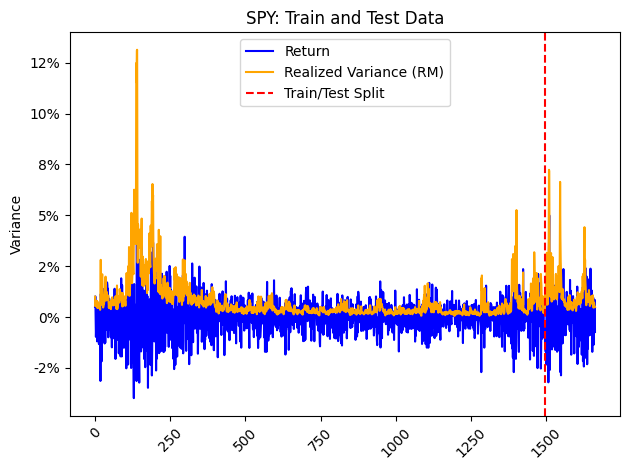

Iteration N30 LLH: -65.8398 H0 = 0.5709
Iteration N50 LLH: -126.3377 H0 = 0.5214
Iteration N60 LLH: -201.4319 H0 = 0.4594
Iteration N70 LLH: -282.3047 H0 = 0.4949
Iteration N90 LLH: -350.3394 H0 = 0.5149
Iteration N110 LLH: -351.5356 H0 = 0.5162
Iteration N120 LLH: -352.2623 H0 = 0.5165
Iteration N130 LLH: -353.3242 H0 = 0.5223
Iteration N140 LLH: -353.5487 H0 = 0.5315
Iteration N150 LLH: -353.6350 H0 = 0.5320
Iteration N160 LLH: -353.6457 H0 = 0.5330
Iteration N170 LLH: -353.6490 H0 = 0.5333
Iteration N180 LLH: -353.6769 H0 = 0.5350
Iteration N190 LLH: -353.7285 H0 = 0.5372
Iteration N200 LLH: -353.8015 H0 = 0.5389
Iteration N220 LLH: -353.8045 H0 = 0.5385
Iteration N230 LLH: -353.8382 H0 = 0.5382
Iteration N240 LLH: -353.8478 H0 = 0.5372
Iteration N250 LLH: -353.8498 H0 = 0.5344
Iteration N260 LLH: -353.8606 H0 = 0.5353
Iteration N270 LLH: -353.8677 H0 = 0.5355
Iteration N280 LLH: -353.8839 H0 = 0.5342
Iteration N290 LLH: -353.9073 H0 = 0.5343
Iteration N300 LLH: -353.9285 H0 = 0.533

In [ ]:
garch = RealizedGARCH(train_data, test_data, "SPY", 'DJIA')
garch.plot_train_test_data()
garch.fit(verbose=True)
garch.print_parameters()

### 2.2 Forecasting

Now we do a one-step-ahead volatility forecast, without recalibration.

$$h_{t} = (h_{t-1})^{\beta_1} \,(x_{t-1})^{\gamma_1} \, (x_{t-2})^{\gamma_2} \cdot e^\omega  $$



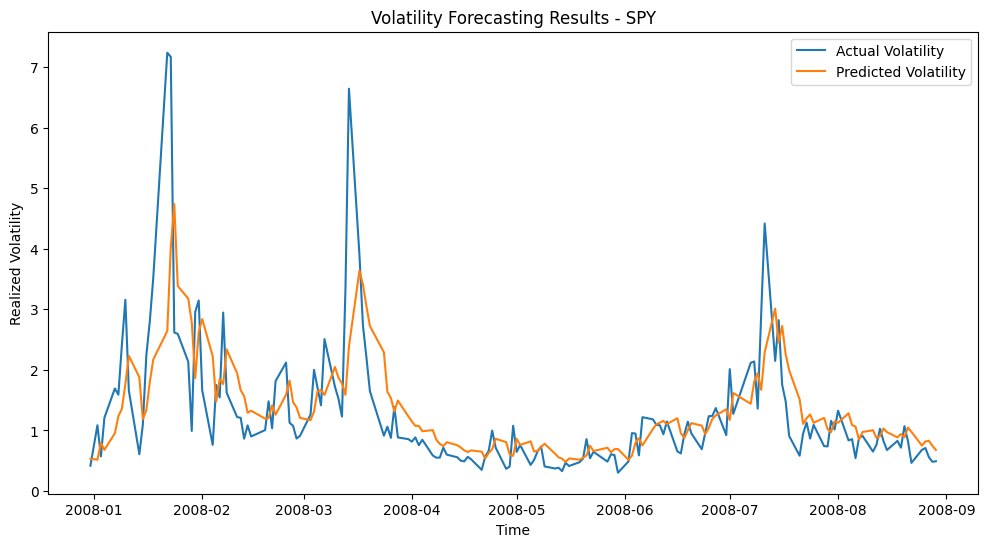

In [ ]:
garch.forecast()
garch.get_forcast_plot()

### 2.3 Performance Measurement

We still have doubts on how to measure the performance of our model predictions since the volatility is unobservable. Some approaches use
$$MSE = \frac{1}{N} \sum_t (\sigma^2_t - h_t)^2, \quad \sigma_t^2 = \frac{1}{M} \sum_{i=0}^M \left(r_{t-i} - \frac{1}{M+1}\sum_{i=0}^M r_{t-i}\right)^2$$
where $M$ is a rolling window size of 5, Zhang (2022). Other variations may includes a weighted average of the recent squared returns.

But since we have the realized measure, this should be the best proxy of the conditional variance of the returns.
I recommend to read Andersen 2008 "Realized Volatility".

In [ ]:
print(garch.get_MSE())

0.6395557441540427


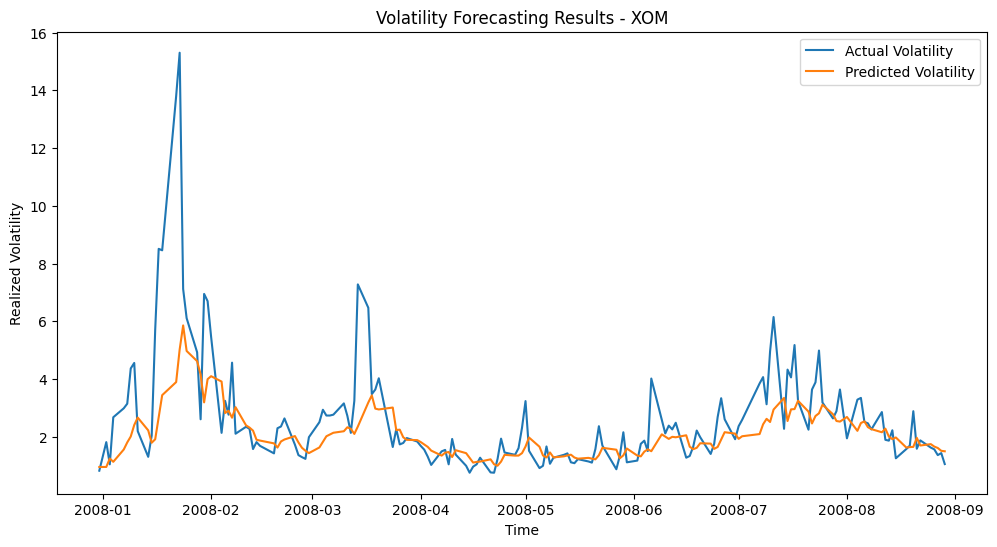

Model Parameters:
omega:    0.0277
beta_1:   0.7048
gamma_1:  0.3390
gamma_2:  -0.1227
xi:       -0.0951
psi:      1.2577
tau_1:    -0.0789
tau_2:    0.0790
sigma2_u: 0.1417
XOM MSE: 2.6879 



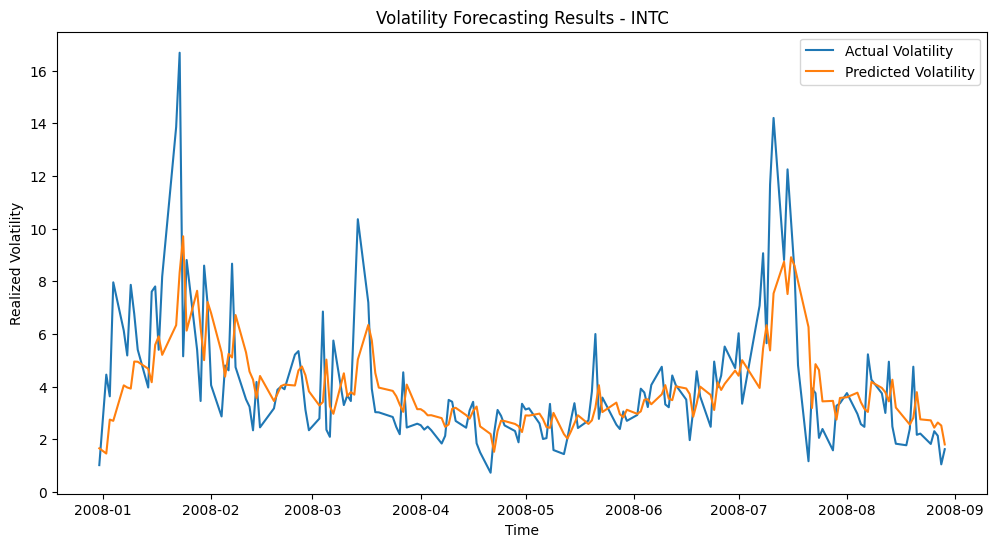

Model Parameters:
omega:    0.0183
beta_1:   0.8540
gamma_1:  0.4524
gamma_2:  -0.3156
xi:       -0.1023
psi:      1.0317
tau_1:    -0.0178
tau_2:    0.0696
sigma2_u: 0.1333
INTC MSE: 3.9565 



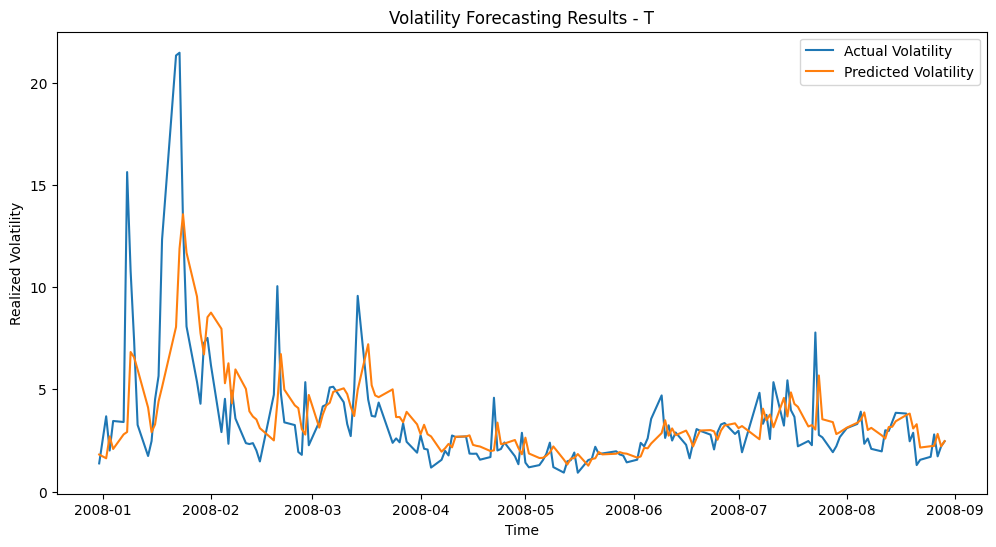

Model Parameters:
omega:    0.0011
beta_1:   0.8598
gamma_1:  0.5313
gamma_2:  -0.3762
xi:       0.0159
psi:      0.8625
tau_1:    -0.0309
tau_2:    0.1038
sigma2_u: 0.2112
T MSE: 5.1295 



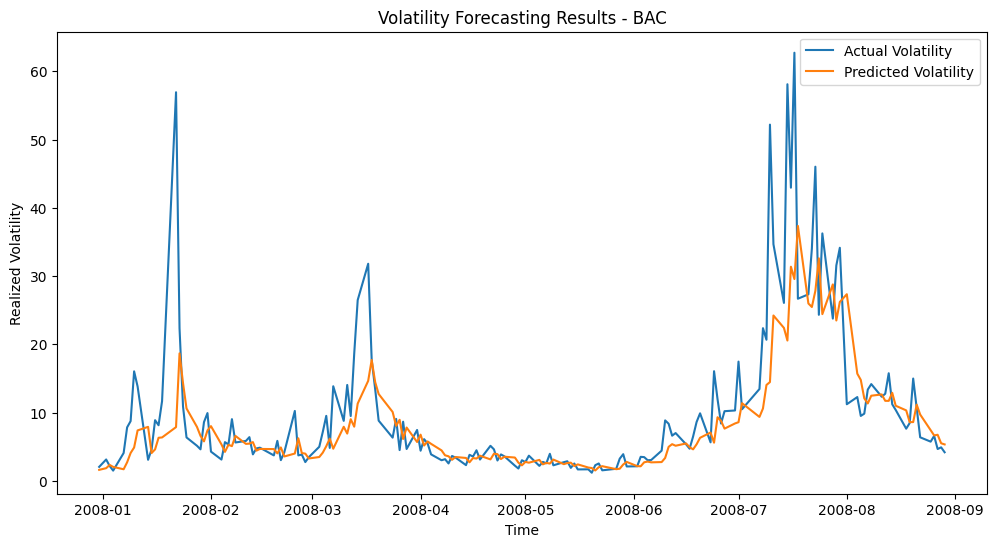

Model Parameters:
omega:    -0.0028
beta_1:   0.7722
gamma_1:  0.5070
gamma_2:  -0.2899
xi:       0.0080
psi:      0.9967
tau_1:    -0.0410
tau_2:    0.0754
sigma2_u: 0.1726
BAC MSE: 58.3126 



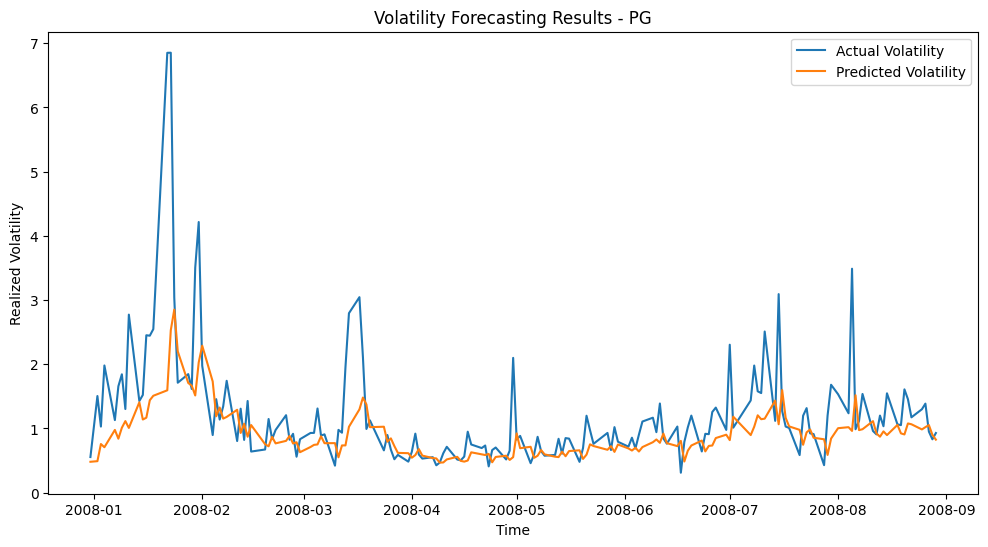

Model Parameters:
omega:    -0.0424
beta_1:   0.7802
gamma_1:  0.4333
gamma_2:  -0.2431
xi:       0.1852
psi:      1.0374
tau_1:    -0.0535
tau_2:    0.0793
sigma2_u: 0.1701
PG MSE: 0.6296 



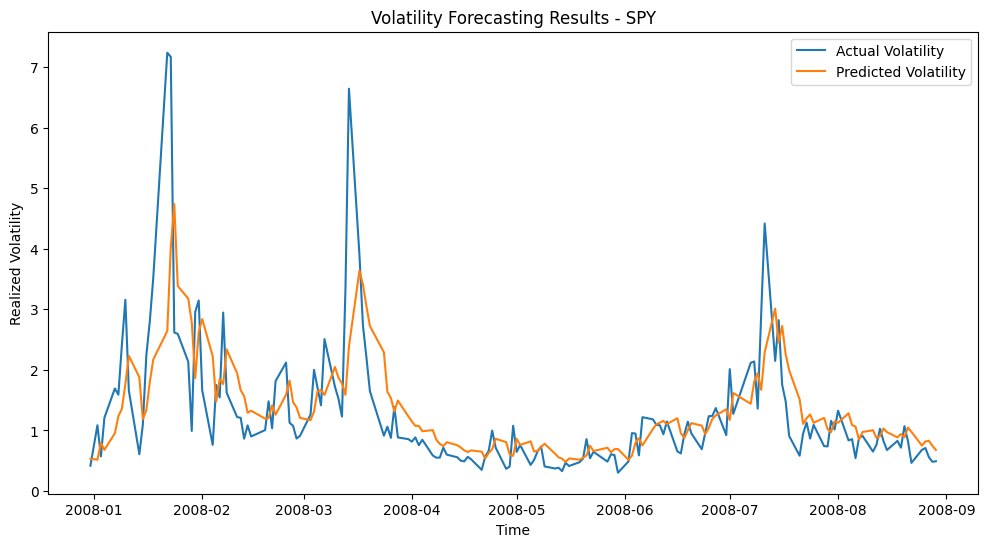

Model Parameters:
omega:    0.0408
beta_1:   0.7004
gamma_1:  0.4498
gamma_2:  -0.1746
xi:       -0.1782
psi:      1.0380
tau_1:    -0.0676
tau_2:    0.0700
sigma2_u: 0.1454
SPY MSE: 0.6396 



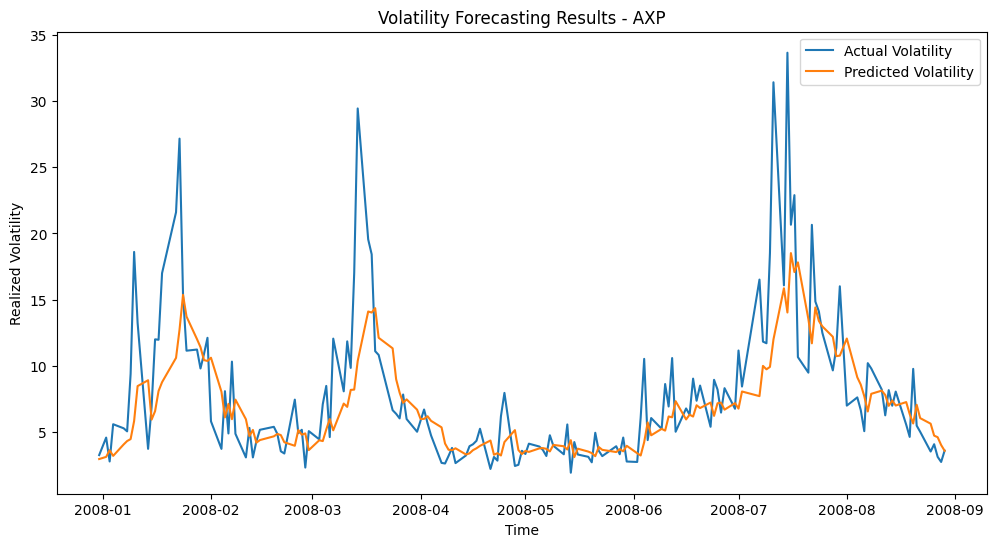

Model Parameters:
omega:    0.0463
beta_1:   0.7077
gamma_1:  0.3820
gamma_2:  -0.1225
xi:       -0.1630
psi:      1.0848
tau_1:    -0.0191
tau_2:    0.0984
sigma2_u: 0.1826
AXP MSE: 17.3606 



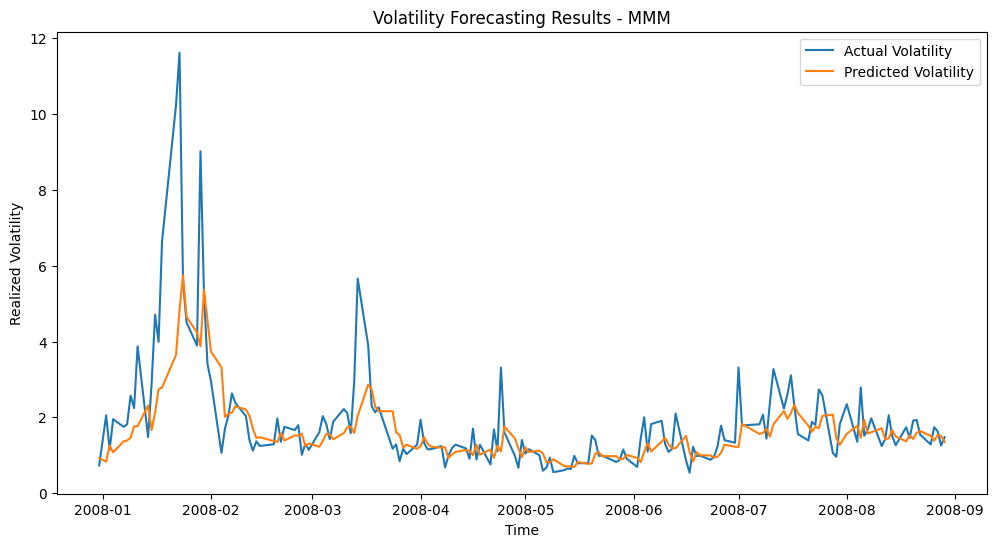

Model Parameters:
omega:    -0.0055
beta_1:   0.7590
gamma_1:  0.4318
gamma_2:  -0.2145
xi:       0.0283
psi:      0.9752
tau_1:    -0.0178
tau_2:    0.0714
sigma2_u: 0.1722
MMM MSE: 1.2543 



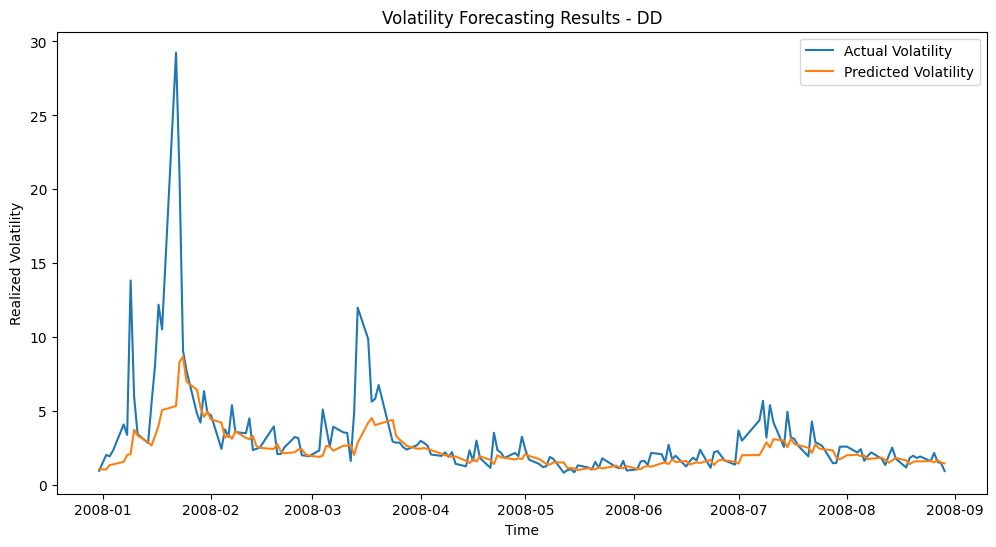

Model Parameters:
omega:    -0.0111
beta_1:   0.7776
gamma_1:  0.3699
gamma_2:  -0.1783
xi:       0.0768
psi:      1.0767
tau_1:    -0.0467
tau_2:    0.0836
sigma2_u: 0.1635
DD MSE: 7.5186 



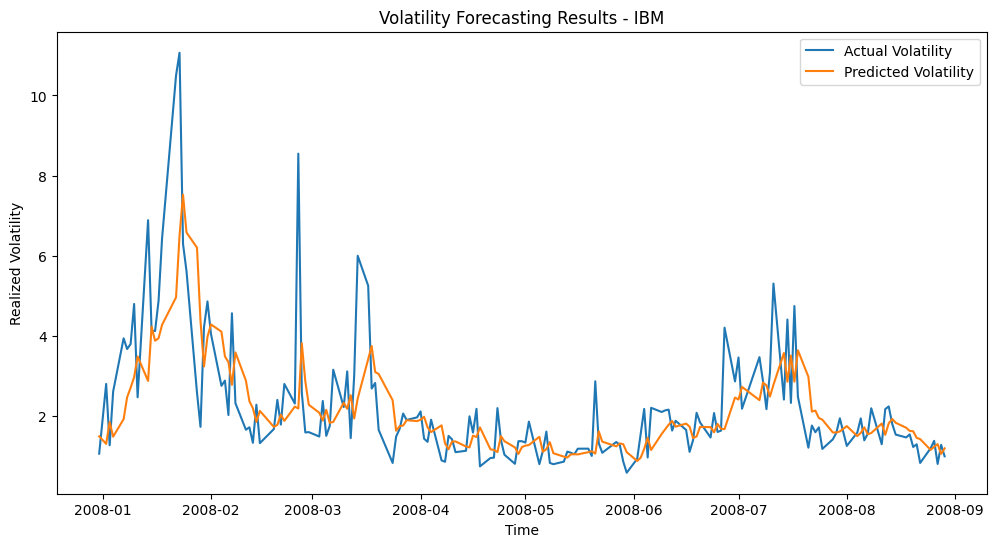

Model Parameters:
omega:    0.0002
beta_1:   0.7410
gamma_1:  0.4145
gamma_2:  -0.1556
xi:       0.0070
psi:      0.9411
tau_1:    -0.0386
tau_2:    0.0820
sigma2_u: 0.1504
IBM MSE: 1.4776 



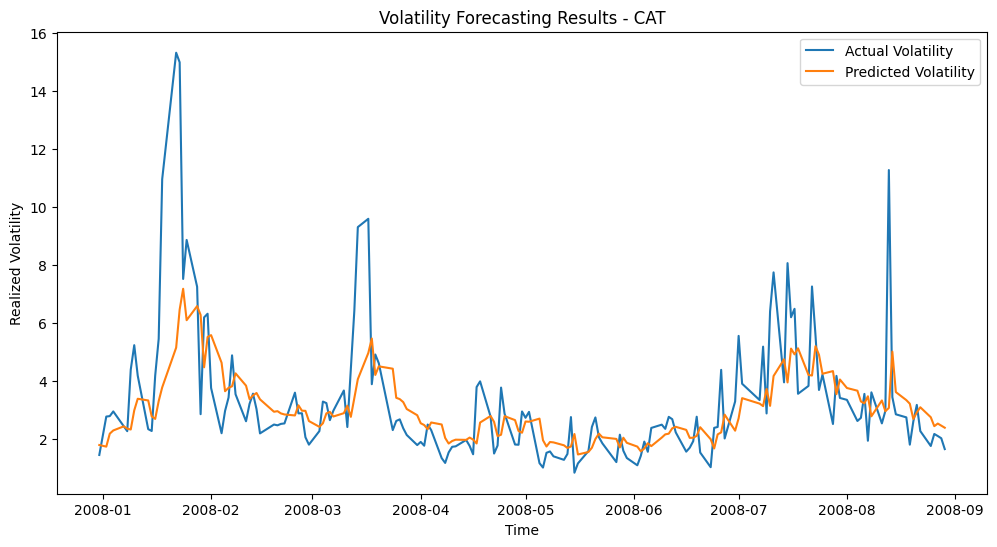

Model Parameters:
omega:    0.0314
beta_1:   0.8220
gamma_1:  0.3694
gamma_2:  -0.2177
xi:       -0.1439
psi:      1.0792
tau_1:    -0.0266
tau_2:    0.0912
sigma2_u: 0.1416
CAT MSE: 3.3202 



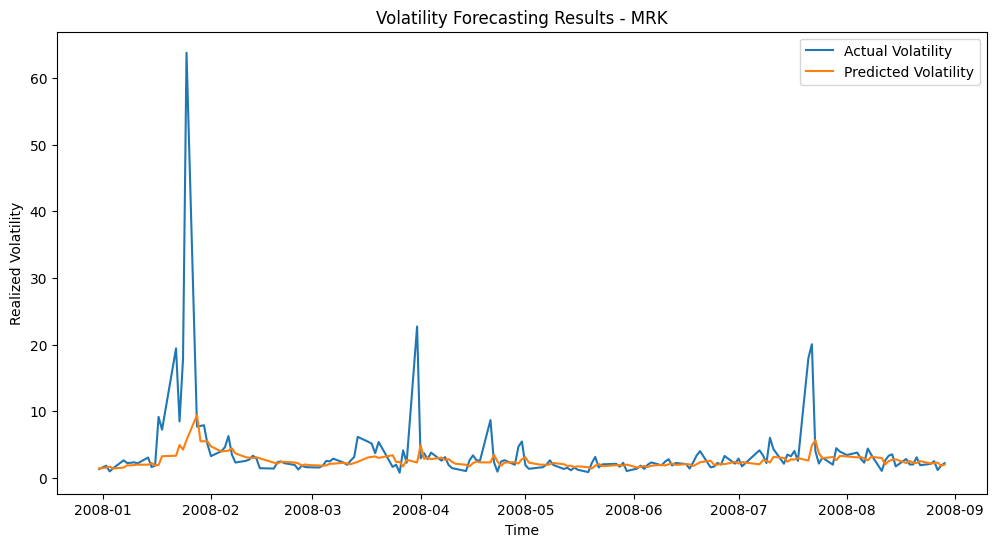

Model Parameters:
omega:    0.0317
beta_1:   0.8362
gamma_1:  0.3278
gamma_2:  -0.2095
xi:       -0.1935
psi:      1.2307
tau_1:    0.0098
tau_2:    0.0673
sigma2_u: 0.2233
MRK MSE: 29.9083 



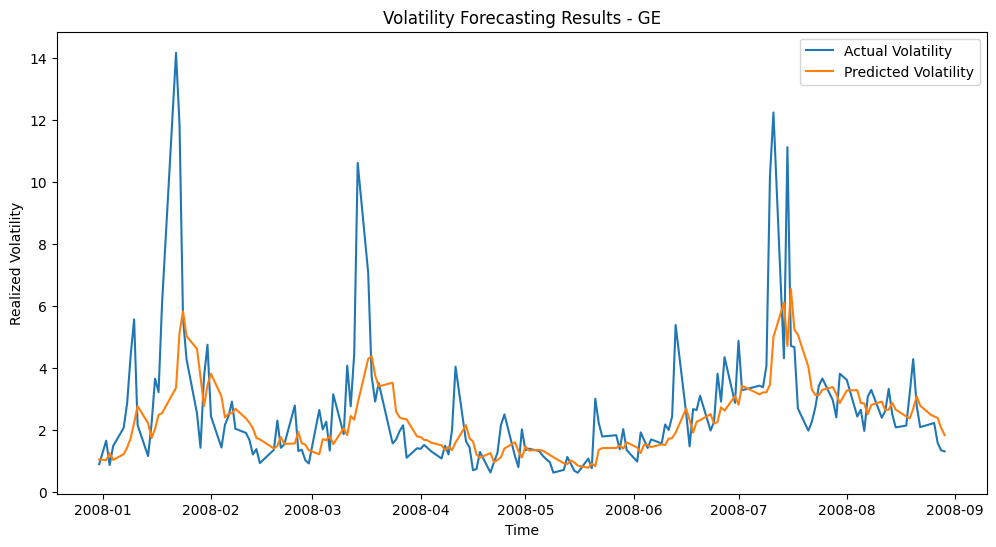

Model Parameters:
omega:    -0.0024
beta_1:   0.8011
gamma_1:  0.3729
gamma_2:  -0.1769
xi:       0.0136
psi:      0.9813
tau_1:    -0.0053
tau_2:    0.0811
sigma2_u: 0.1694
GE MSE: 3.1603 



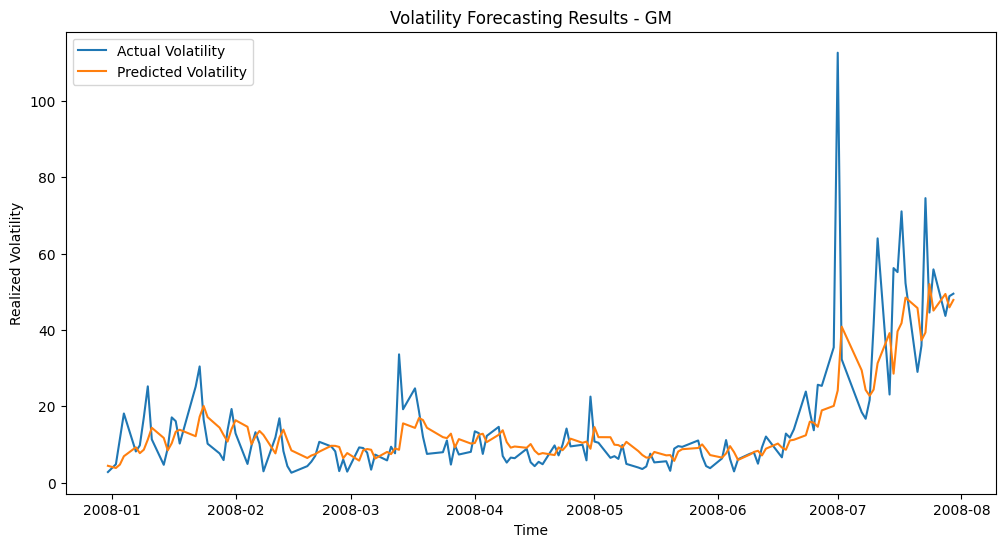

Model Parameters:
omega:    0.0629
beta_1:   0.8330
gamma_1:  0.3910
gamma_2:  -0.2391
xi:       -0.3234
psi:      1.0227
tau_1:    -0.0052
tau_2:    0.1215
sigma2_u: 0.2182
GM MSE: 117.2790 



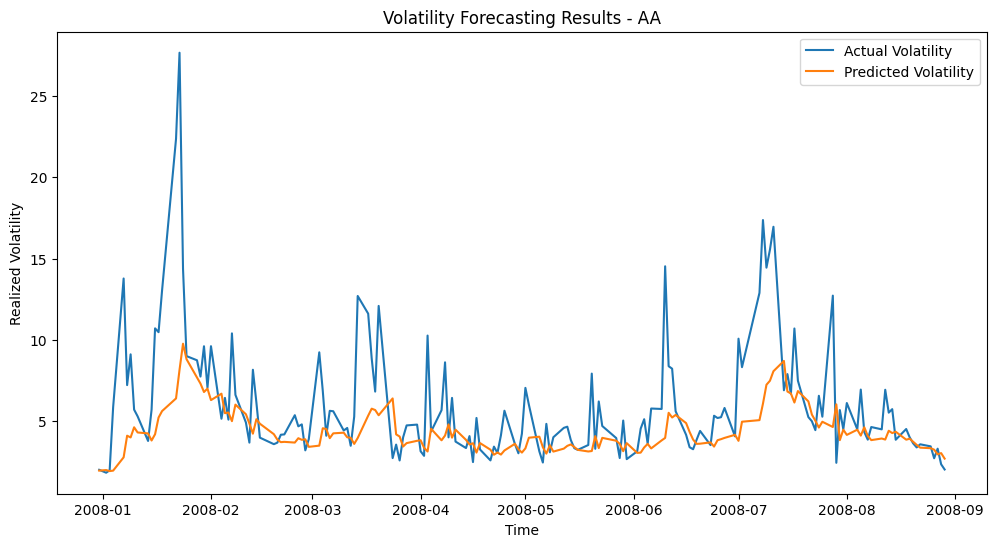

Model Parameters:
omega:    0.0306
beta_1:   0.7692
gamma_1:  0.3221
gamma_2:  -0.1402
xi:       -0.0707
psi:      1.1544
tau_1:    -0.0363
tau_2:    0.0899
sigma2_u: 0.1590
AA MSE: 12.9313 



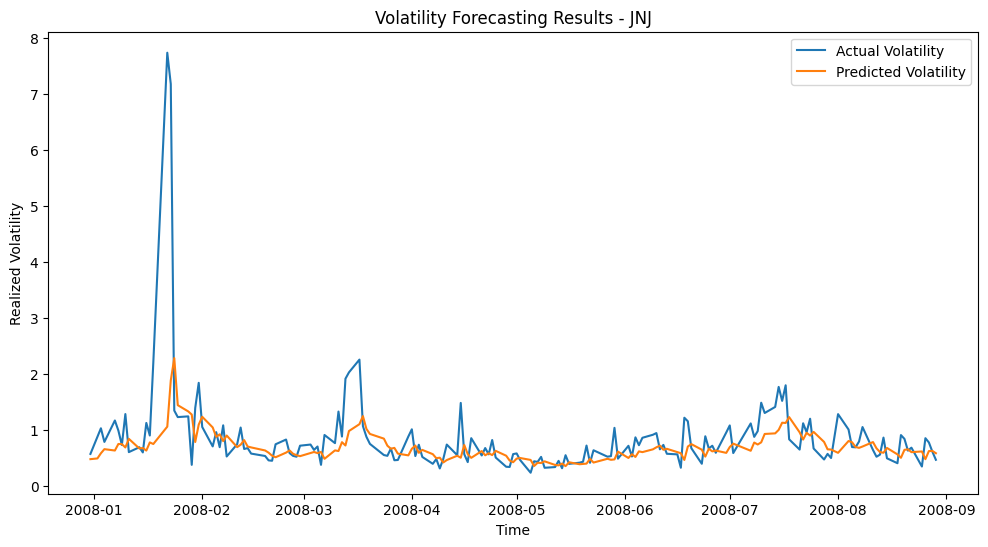

Model Parameters:
omega:    -0.0273
beta_1:   0.7980
gamma_1:  0.3749
gamma_2:  -0.1913
xi:       0.1286
psi:      1.0455
tau_1:    0.0151
tau_2:    0.1010
sigma2_u: 0.1963
JNJ MSE: 0.5583 



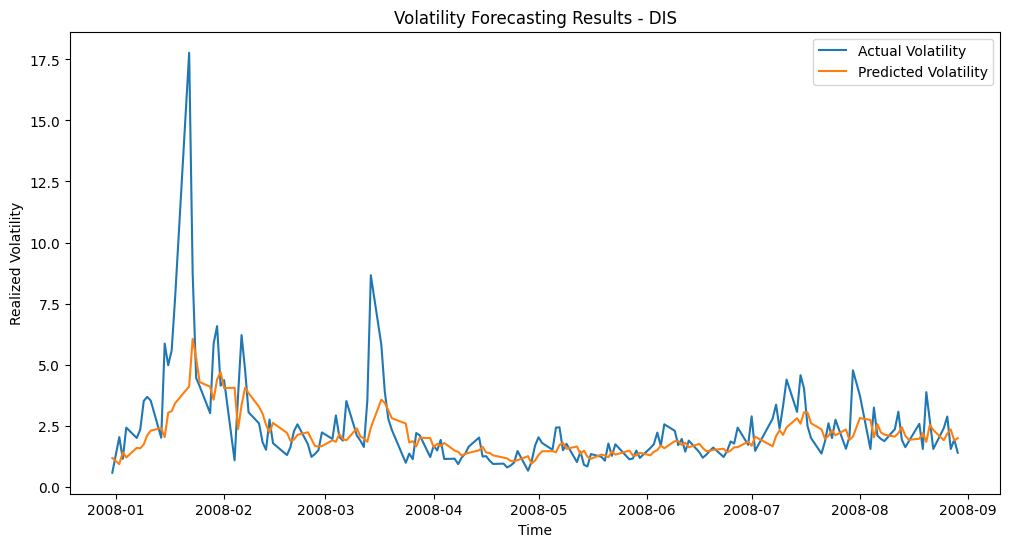

Model Parameters:
omega:    0.0087
beta_1:   0.8303
gamma_1:  0.3804
gamma_2:  -0.2316
xi:       -0.0413
psi:      1.1038
tau_1:    -0.0409
tau_2:    0.0895
sigma2_u: 0.1657
DIS MSE: 2.3481 



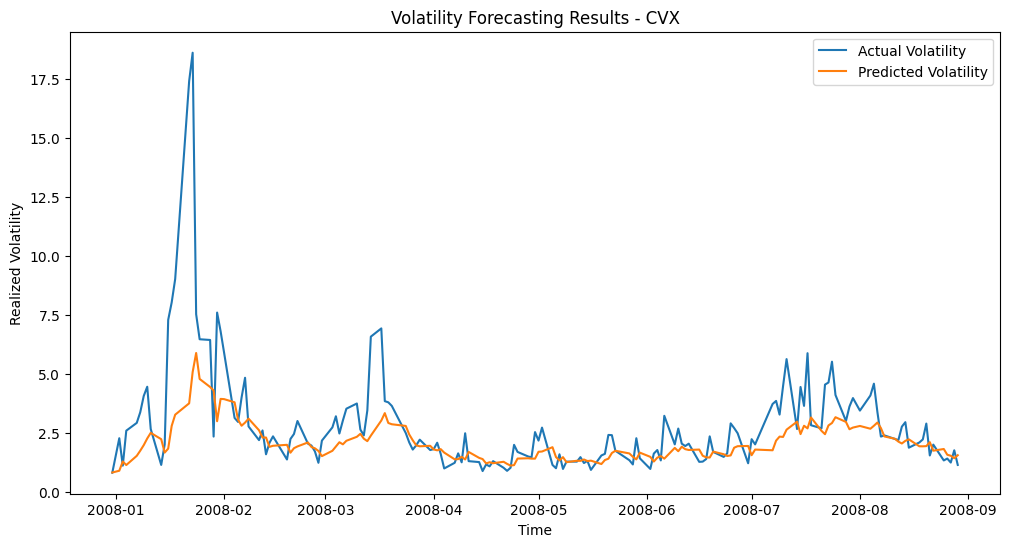

Model Parameters:
omega:    0.0270
beta_1:   0.7141
gamma_1:  0.3346
gamma_2:  -0.1376
xi:       -0.1005
psi:      1.3173
tau_1:    -0.0762
tau_2:    0.0785
sigma2_u: 0.1503
CVX MSE: 3.9601 



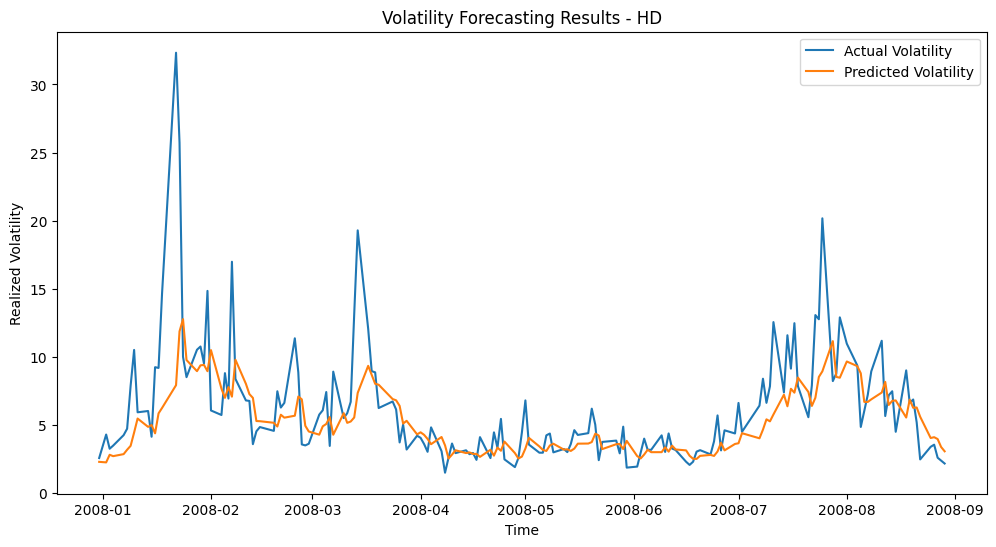

Model Parameters:
omega:    0.0063
beta_1:   0.7911
gamma_1:  0.3931
gamma_2:  -0.1994
xi:       0.0039
psi:      1.0125
tau_1:    -0.0457
tau_2:    0.0916
sigma2_u: 0.1665
HD MSE: 11.8545 



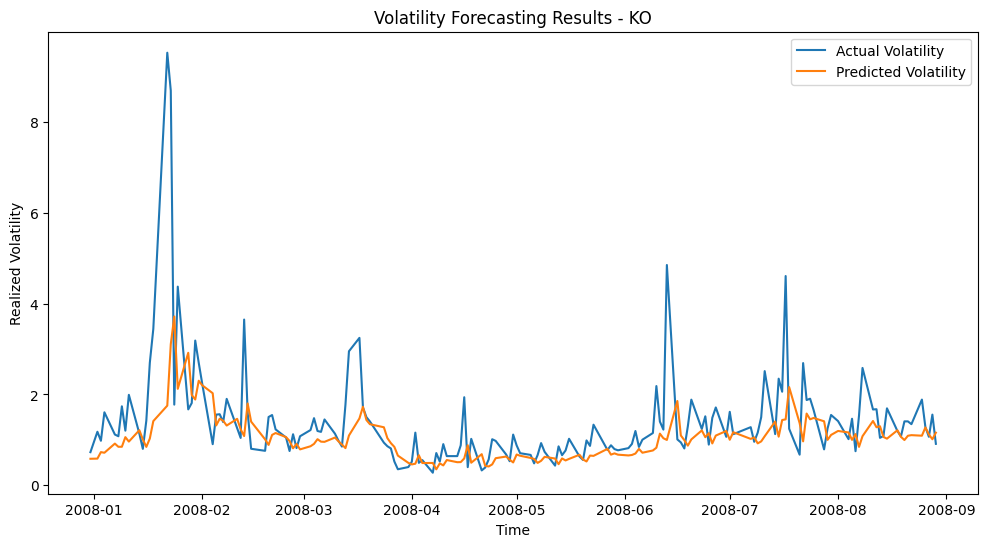

Model Parameters:
omega:    -0.0486
beta_1:   0.7654
gamma_1:  0.4509
gamma_2:  -0.2135
xi:       0.1881
psi:      0.9349
tau_1:    -0.0187
tau_2:    0.0746
sigma2_u: 0.1469
KO MSE: 1.0997 



In [ ]:
import time
split_date = '2007-12-31'
DJIA_Garch = {}
fit_durations = []
prediction_durations = []
for col in DJIA.keys():
  DJIA_Garch[col] = RealizedGARCH(DJIA[col][:DJIA_SPLIT_DATE], DJIA[col][DJIA_SPLIT_DATE:], col, '')

  start_time = time.time()
  DJIA_Garch[col].fit(verbose=False)
  end_time = time.time()
  fit_duration = end_time-start_time
  fit_durations.append(fit_duration)

  start_time = time.time()
  DJIA_Garch[col].forecast()
  end_time = time.time()
  prediction_durations.append(end_time-start_time)

  DJIA_Garch[col].get_forcast_plot()
  DJIA_Garch[col].print_parameters()
  print(f"{col} MSE: {DJIA_Garch[col].get_MSE():.4f} \n")

In [ ]:
print(len(fit_durations))
mean_time = np.mean(fit_durations)
stdev_time = np.std(fit_durations, ddof=1)  # Use ddof=1 for sample standard deviation

print(f"Mean time: {mean_time:.4f} seconds")
print(f"Standard deviation: {stdev_time:.4f} seconds")

mean_time = np.mean(prediction_durations)
stdev_time = np.std(prediction_durations, ddof=1)  # Use ddof=1 for sample standard deviation

print(f"Mean time: {mean_time:.4f} seconds")
print(f"Standard deviation: {stdev_time:.4f} seconds")

20
Mean time: 10.3865 seconds
Standard deviation: 1.2949 seconds
Mean time: 0.0134 seconds
Standard deviation: 0.0026 seconds


Let's try with the newer dataset NASDAQ100. (e.g. Apple stock)

In [ ]:
split_date = '2016-12-31'
garch_apple = RealizedGARCH(NDX["AAPL"][:split_date],  NDX["AAPL"][split_date:], "AAPL")
garch_apple.fit(verbose=True)
garch_apple.print_parameters()

Iteration N20 LLH: 26466.6852 H0 = 0.1334
Iteration N30 LLH: 12716.5319 H0 = 0.1688
Iteration N40 LLH: 7409.4812 H0 = 0.1962
Iteration N50 LLH: 5013.9925 H0 = 0.2187
Iteration N60 LLH: 4641.7174 H0 = 0.2286
Iteration N70 LLH: 4572.8258 H0 = 0.2351
Iteration N80 LLH: 3965.5171 H0 = 0.3225
Iteration N90 LLH: 3377.1546 H0 = 0.5071
Iteration N100 LLH: 2896.6709 H0 = 0.7006
Iteration N110 LLH: 2569.3574 H0 = 1.0307
Iteration N120 LLH: 2274.5545 H0 = 1.2151
Iteration N130 LLH: 2175.4280 H0 = 0.9909
Iteration N140 LLH: 2100.3750 H0 = 1.1725
Iteration N150 LLH: 2023.4005 H0 = 1.4775
Iteration N160 LLH: 1934.9495 H0 = 1.9267
Iteration N170 LLH: 1804.6749 H0 = 2.2278
Iteration N180 LLH: 1733.5911 H0 = 1.6947
Iteration N190 LLH: 1721.4916 H0 = 2.3185
Iteration N200 LLH: 1697.4832 H0 = 2.1307
Iteration N220 LLH: 1682.9045 H0 = 2.0548
Iteration N230 LLH: 1675.4469 H0 = 2.0963
Iteration N240 LLH: 1673.6476 H0 = 2.1327
Iteration N250 LLH: 1673.4200 H0 = 2.1413
Iteration N260 LLH: 1672.8190 H0 = 2.172

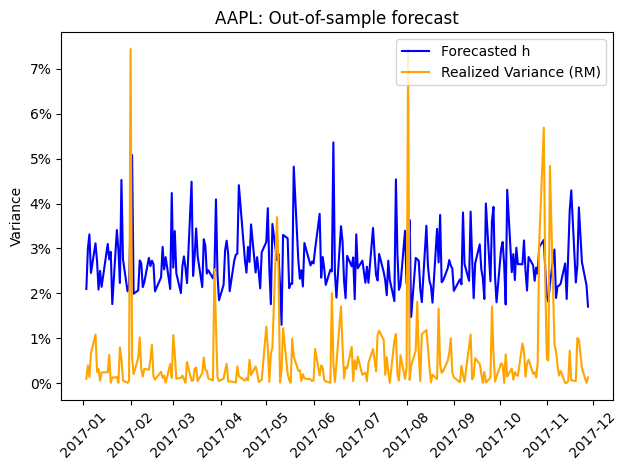

In [ ]:
garch_apple.forecast()
garch_apple.get_forcast_plot()

In [ ]:
print(garch_apple.get_MSE())

5.850794907289069


#### 2.3.1 Obtaining and Saving Performance Measures

In [ ]:
# this block of code is for getting the volatility of the test set for each stock index.

from google.colab import files

with open('./DJIA_Test_Set_Variance.csv', 'w') as file:
  file.write('ticker, variance\n')
  djia_tickers = list(DJIA.keys())
  for counter, ticker in enumerate(djia_tickers):
    print(f'Saving Volatility Information... Progress: {counter+1}/{len(djia_tickers)} - {ticker}')

    test_data = DJIA[ticker][:DJIA_SPLIT_DATE]
    volatility = np.var(test_data['RM'])

    # Save Results
    string_to_write = f"{ticker}, {volatility}\n"
    file.write(string_to_write)
    print('\t' + string_to_write[:-1])

files.download('./DJIA_Test_Set_Variance.csv')

Saving Volatility Information... Progress: 1/20 - XOM
	XOM, 3.9404453446382144
Saving Volatility Information... Progress: 2/20 - INTC
	INTC, 16.663499318247325
Saving Volatility Information... Progress: 3/20 - T
	T, 14.17159888113649
Saving Volatility Information... Progress: 4/20 - BAC
	BAC, 3.5566488017875506
Saving Volatility Information... Progress: 5/20 - PG
	PG, 1.0323485520502391
Saving Volatility Information... Progress: 6/20 - SPY
	SPY, 1.0858889023280451
Saving Volatility Information... Progress: 7/20 - AXP
	AXP, 12.760786017848561
Saving Volatility Information... Progress: 8/20 - MMM
	MMM, 1.796582799017609
Saving Volatility Information... Progress: 9/20 - DD
	DD, 4.814721455162005
Saving Volatility Information... Progress: 10/20 - IBM
	IBM, 3.278776592942882
Saving Volatility Information... Progress: 11/20 - CAT
	CAT, 3.3827075014790875
Saving Volatility Information... Progress: 12/20 - MRK
	MRK, 10.265756248484267
Saving Volatility Information... Progress: 13/20 - GE
	GE, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Performing R-GARCH Evaluations. Progress: 1/20 - XOM
(1495, 3) (167, 3)


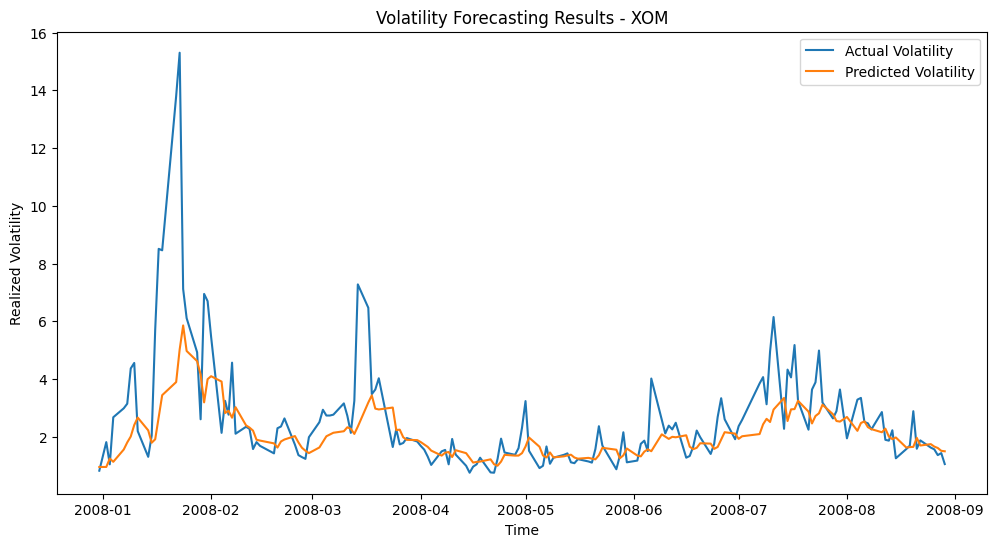

	XOM, 2.688059282823569, 0.8706335098108873, 1.639530201863805
Performing R-GARCH Evaluations. Progress: 2/20 - INTC
(1495, 3) (167, 3)


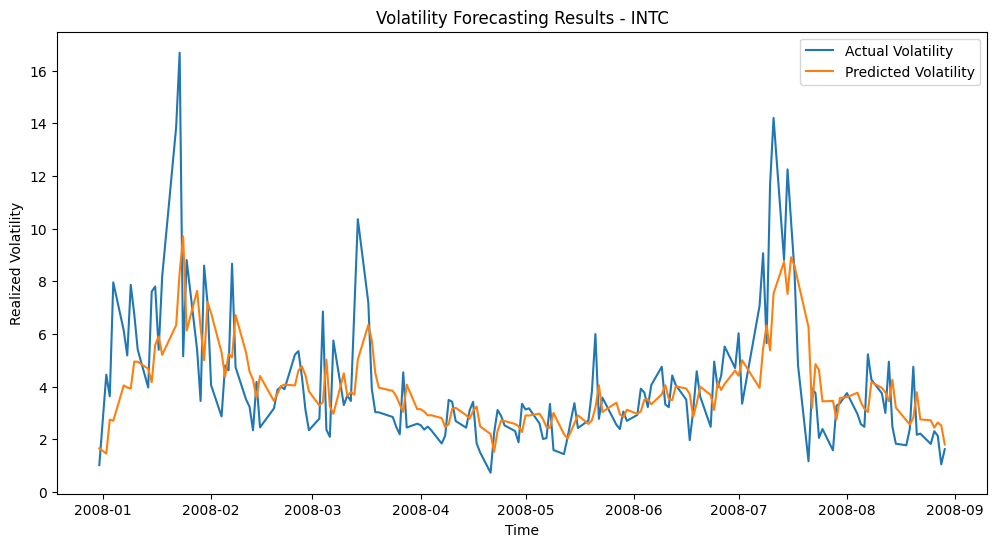

	INTC, 3.9567395549205027, 1.361746683318023, 1.9891554878692874
Performing R-GARCH Evaluations. Progress: 3/20 - T
(1488, 3) (167, 3)


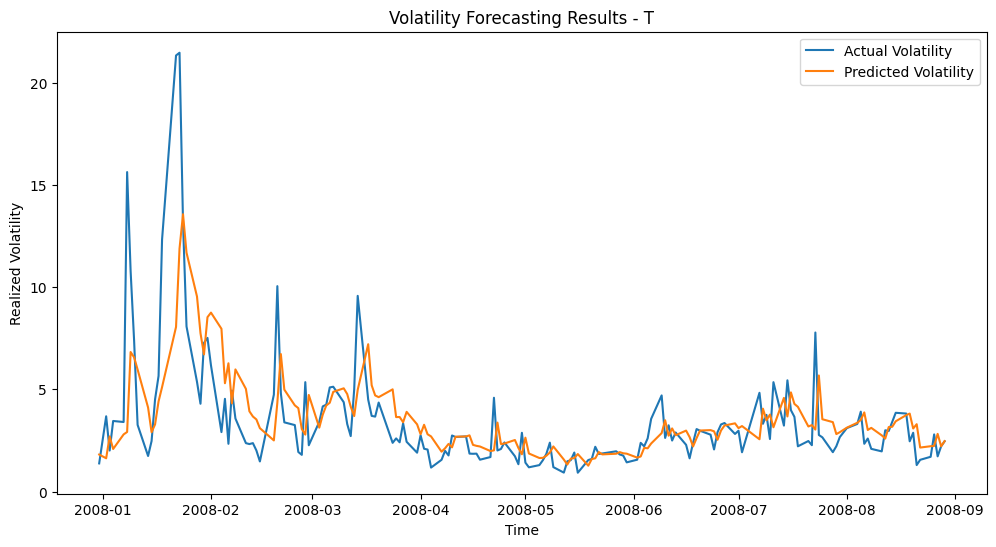

	T, 5.129479064293848, 1.2940281778909761, 2.2648353282951605
Performing R-GARCH Evaluations. Progress: 4/20 - BAC
(1495, 3) (167, 3)


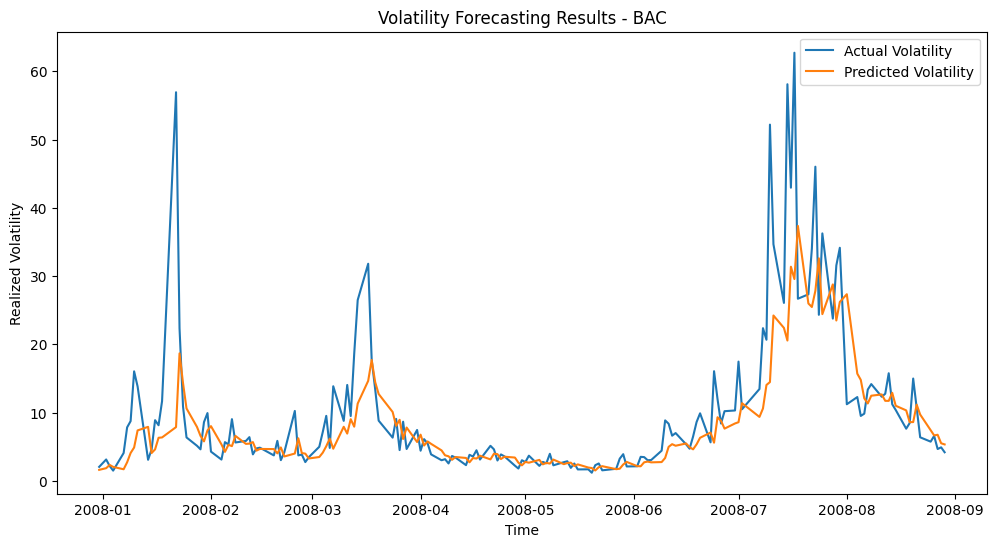

	BAC, 58.31266892323399, 3.745696990434773, 7.6362732352394245
Performing R-GARCH Evaluations. Progress: 5/20 - PG
(1495, 3) (167, 3)


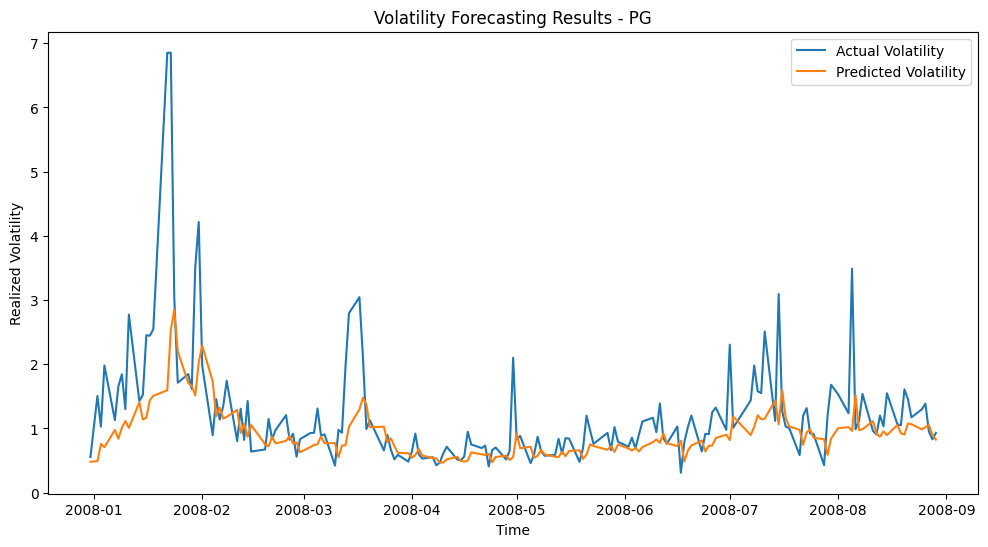

	PG, 0.6295514537979594, 0.43665186914671156, 0.7934427854596444
Performing R-GARCH Evaluations. Progress: 6/20 - SPY
(1495, 3) (168, 3)


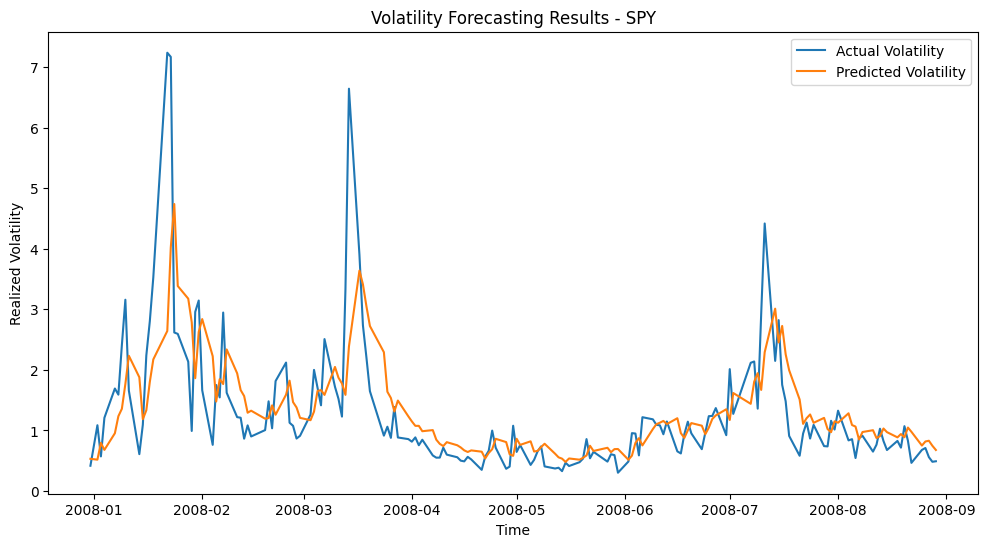

	SPY, 0.6395576953378579, 0.490763047374479, 0.7997235118075858
Performing R-GARCH Evaluations. Progress: 7/20 - AXP
(1495, 3) (167, 3)


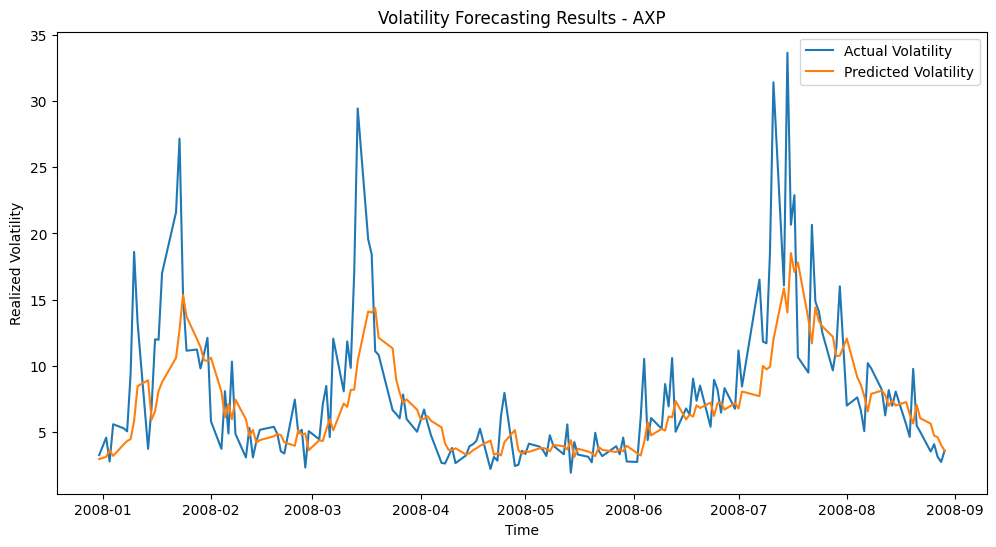

	AXP, 17.360854317176447, 2.510663306540971, 4.166635851280557
Performing R-GARCH Evaluations. Progress: 8/20 - MMM
(1495, 3) (167, 3)


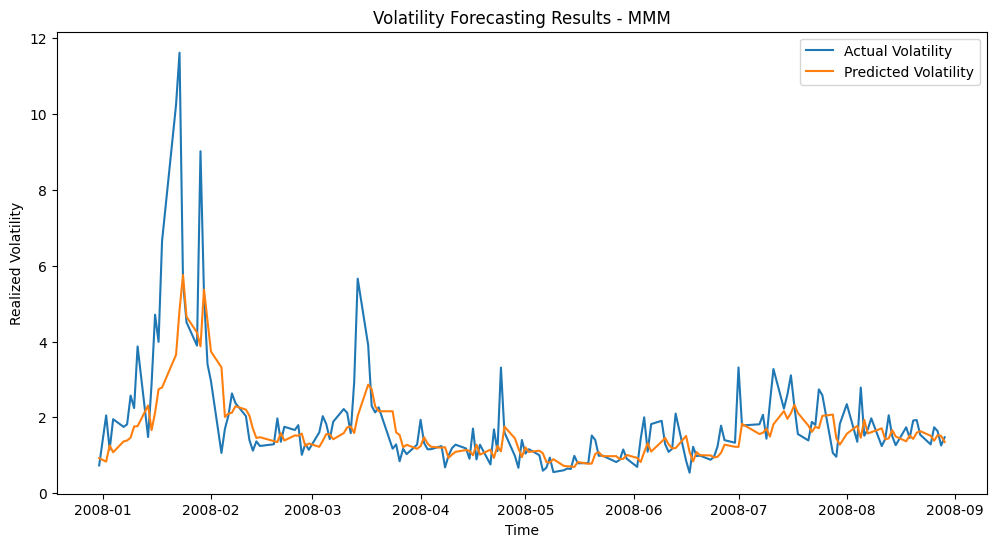

	MMM, 1.2542528175370473, 0.5812867860883177, 1.1199342916158284
Performing R-GARCH Evaluations. Progress: 9/20 - DD
(1495, 3) (167, 3)


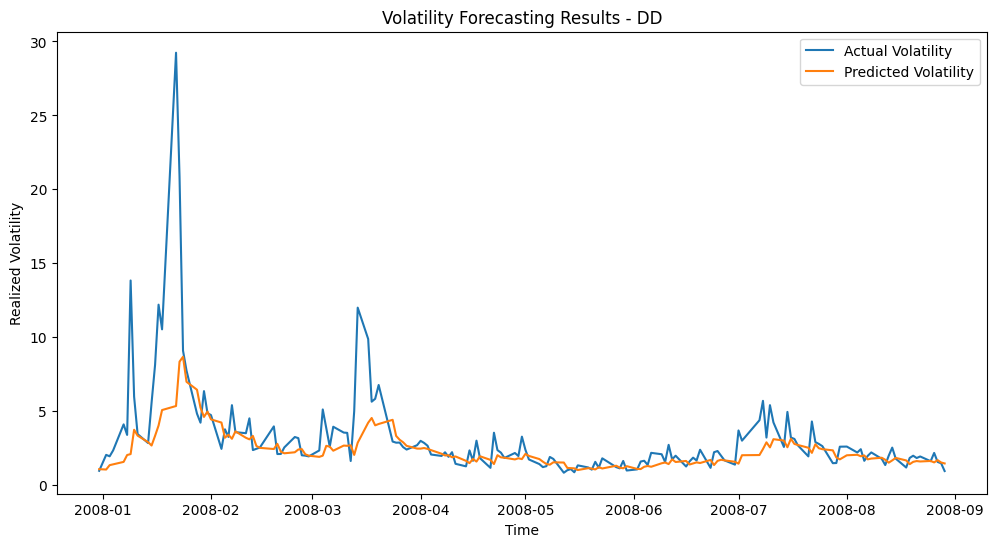

	DD, 7.518711295159146, 1.1231968086542263, 2.742026858941966
Performing R-GARCH Evaluations. Progress: 10/20 - IBM
(1495, 3) (167, 3)


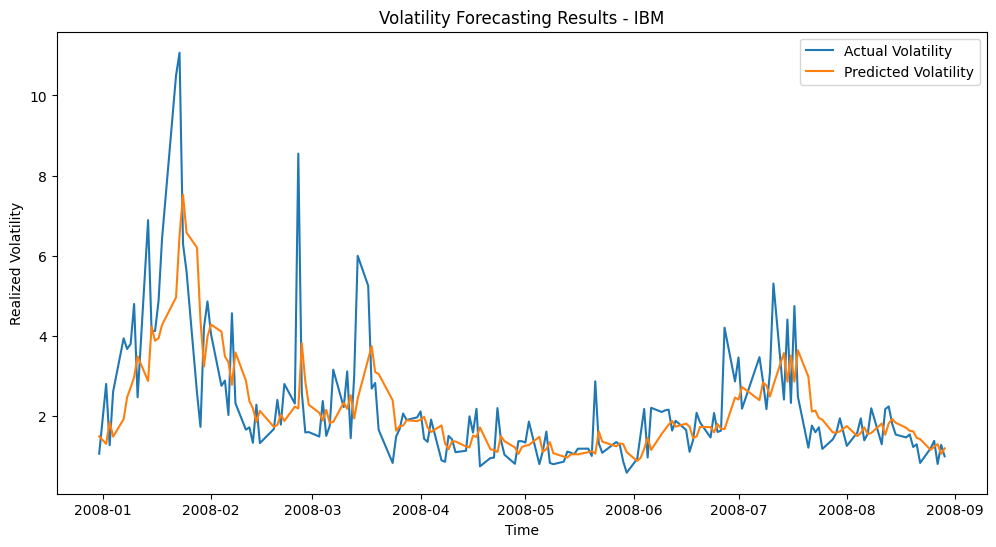

	IBM, 1.4776202610808173, 0.7623136844926526, 1.21557404590622
Performing R-GARCH Evaluations. Progress: 11/20 - CAT
(1495, 3) (167, 3)


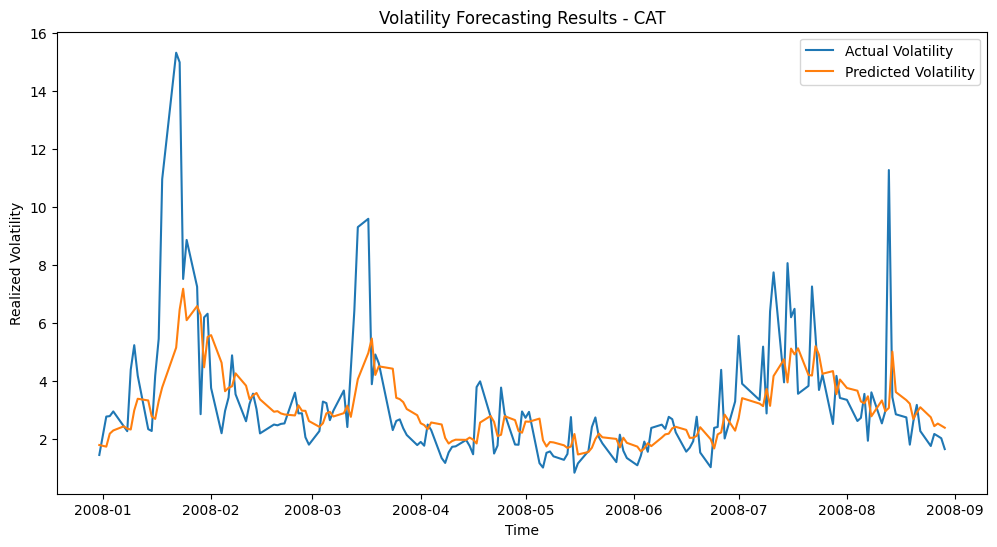

	CAT, 3.320079515550454, 1.0779732342213018, 1.8221085356120952
Performing R-GARCH Evaluations. Progress: 12/20 - MRK
(1495, 3) (167, 3)


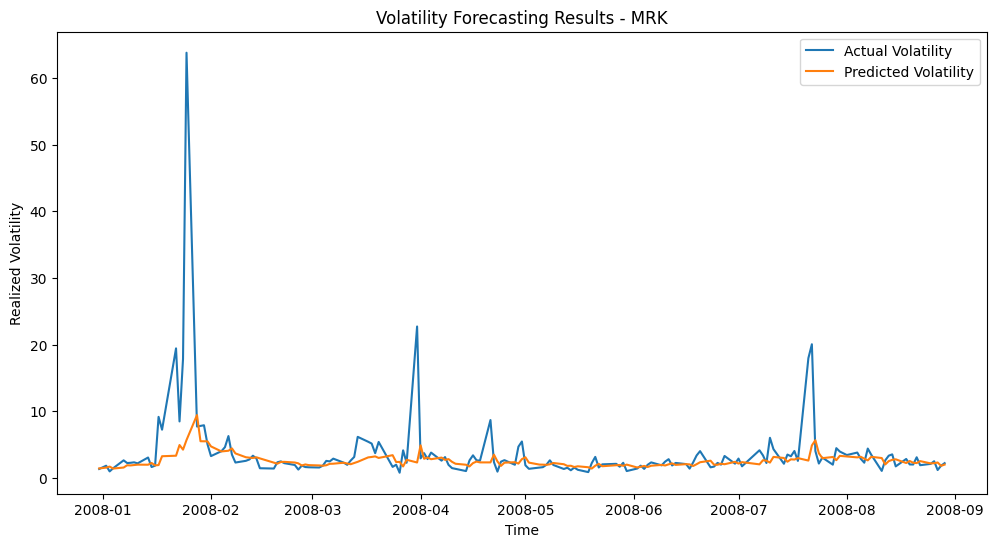

	MRK, 29.908702361611823, 1.6957458513102956, 5.468884928539987
Performing R-GARCH Evaluations. Progress: 13/20 - GE
(1495, 3) (167, 3)


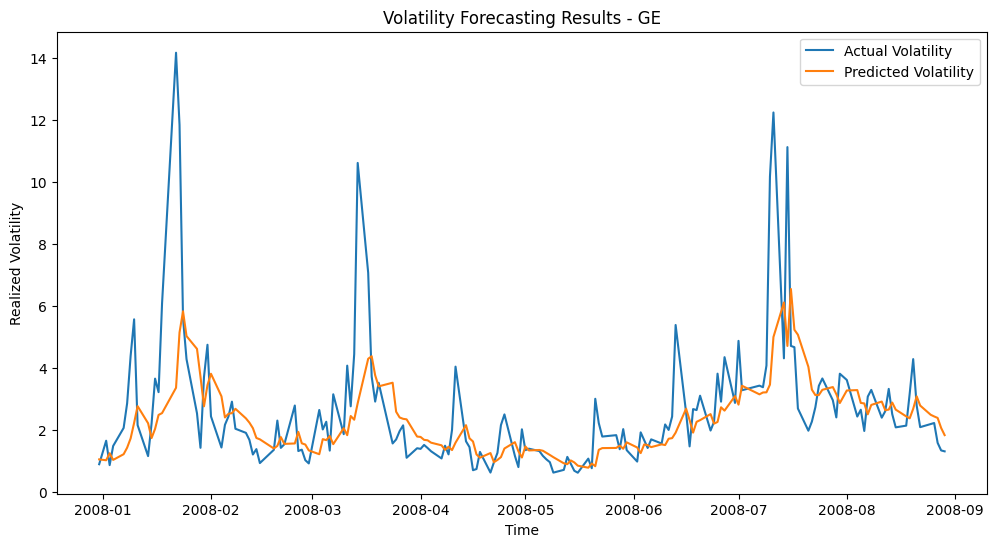

	GE, 3.16032205018186, 0.978305170484112, 1.7777294648460602
Performing R-GARCH Evaluations. Progress: 14/20 - GM
(1495, 3) (146, 3)


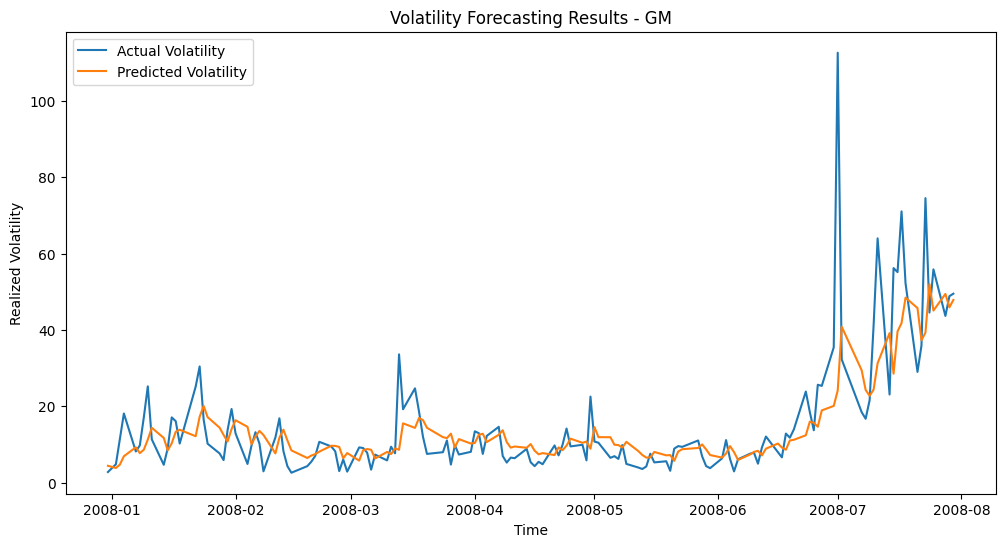

	GM, 117.27978246370265, 5.830867916204445, 10.829579052931958
Performing R-GARCH Evaluations. Progress: 15/20 - AA
(1495, 3) (168, 3)


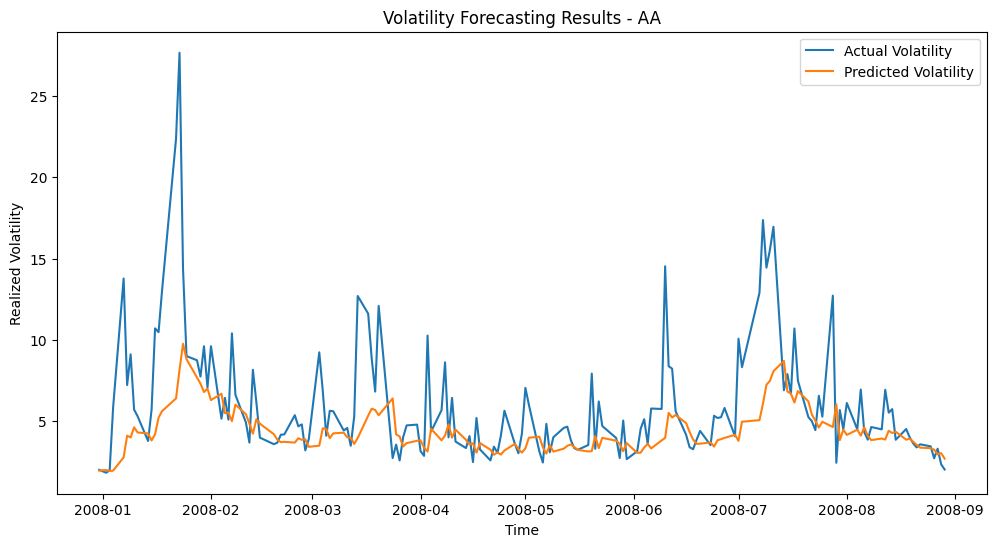

	AA, 12.932544466257943, 2.1004468714749702, 3.596184709696923
Performing R-GARCH Evaluations. Progress: 16/20 - JNJ
(1495, 3) (167, 3)


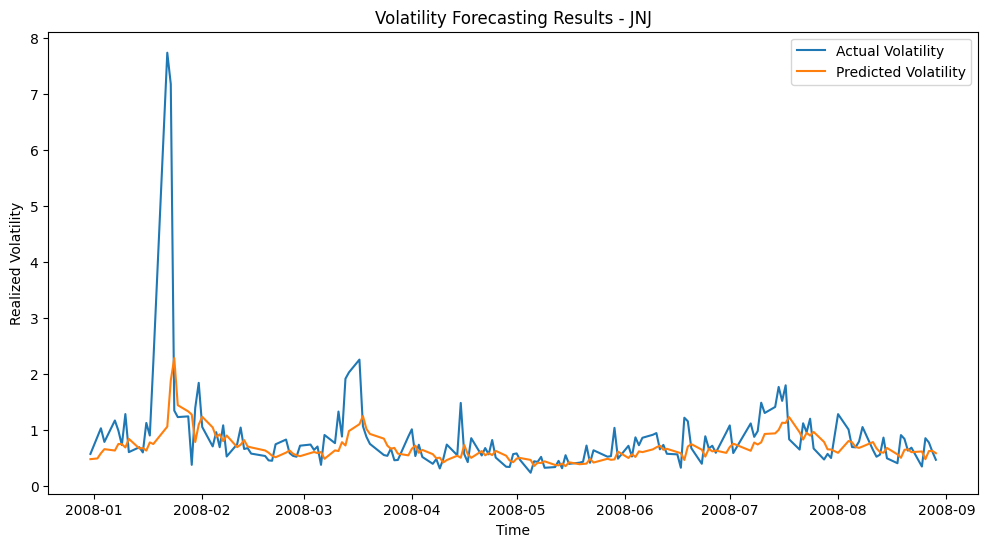

	JNJ, 0.5583211671858367, 0.31609562641576916, 0.7472089180315212
Performing R-GARCH Evaluations. Progress: 17/20 - DIS
(1495, 3) (167, 3)


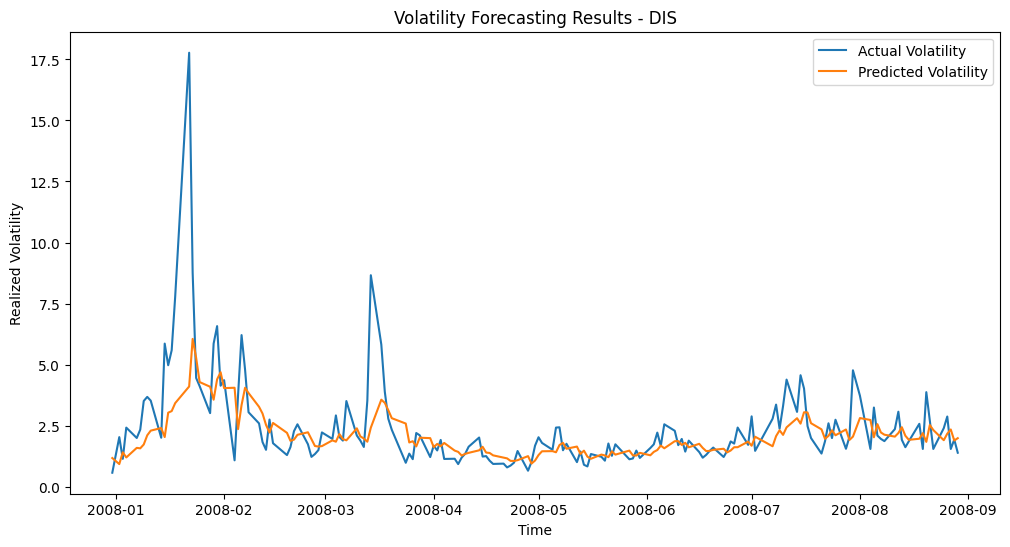

	DIS, 2.3480895422799137, 0.8071454898292274, 1.5323477223789363
Performing R-GARCH Evaluations. Progress: 18/20 - CVX
(1495, 3) (167, 3)


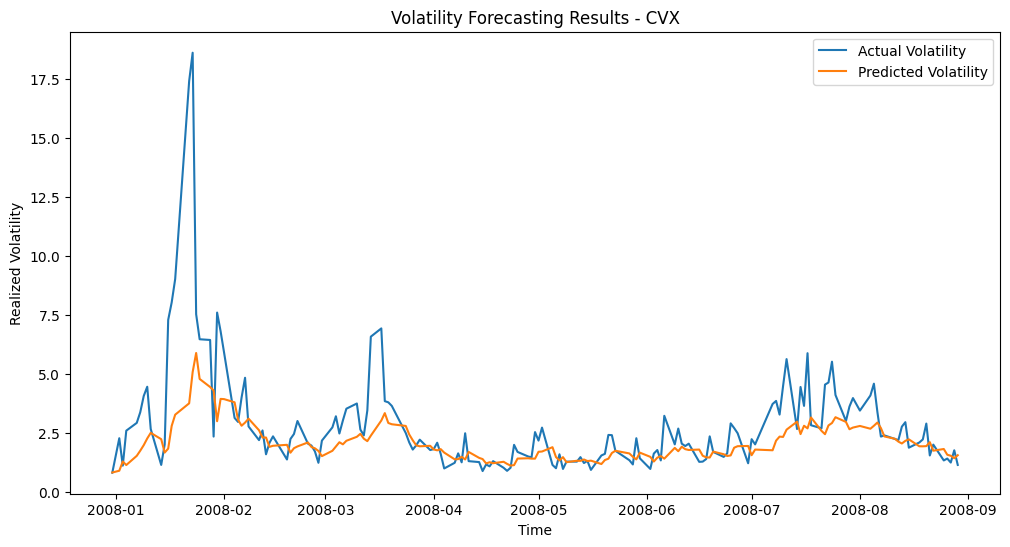

	CVX, 3.9600398039586806, 0.9940943236942407, 1.9899848753090261
Performing R-GARCH Evaluations. Progress: 19/20 - HD
(1495, 3) (167, 3)


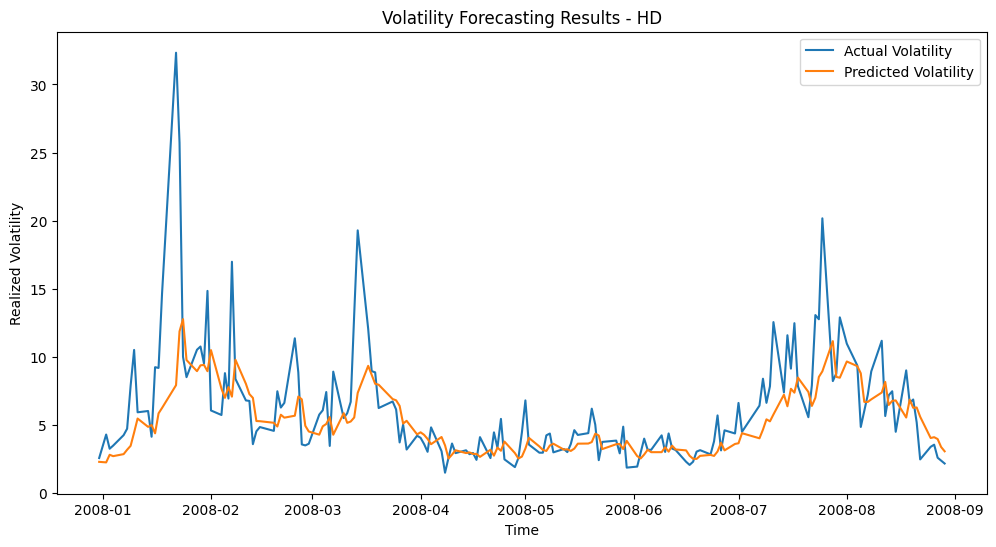

	HD, 11.85432790218137, 1.9621560621537457, 3.4430114583285034
Performing R-GARCH Evaluations. Progress: 20/20 - KO
(1495, 3) (167, 3)


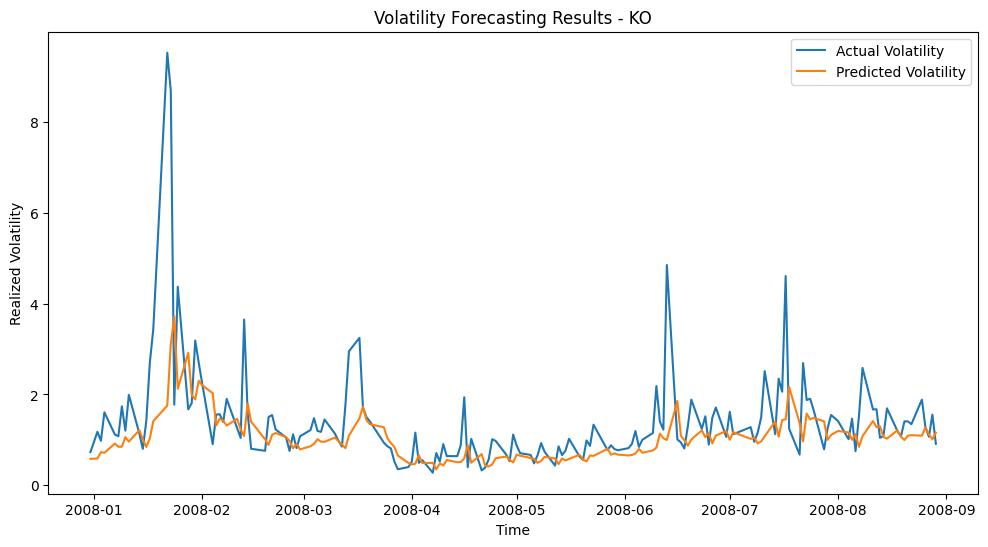

	KO, 1.0996576321723863, 0.5432109867772766, 1.048645618010387


In [ ]:
from google.colab import files

# Getting and Saving GARCH Performance Measures on DJIA time series...
with open('./DJIA_Performance_Measures_GARCH.csv', 'w') as file:
  file.write('ticker, MSE, MAE, RMSE\n')
  djia_tickers = list(DJIA.keys())
  for counter, ticker in enumerate(djia_tickers):
    print(f'Performing R-GARCH Evaluations. Progress: {counter+1}/{len(djia_tickers)} - {ticker}')

    train_data = DJIA[ticker][:DJIA_SPLIT_DATE]
    test_data = DJIA[ticker][DJIA_SPLIT_DATE:]

    print(
        train_data.shape,
        test_data.shape,
    )

    # Train and Evaluate
    garch = RealizedGARCH(train_data, test_data, ticker, index='DJIA')
    garch.fit(verbose=False)
    garch.forecast()
    garch.get_forcast_plot()
    performance_measures = garch.get_performance_measures()

    # Save Results
    string_to_write = f"{ticker}, {performance_measures['MSE']}, {performance_measures['MAE']}, {performance_measures['RMSE']}\n"
    file.write(string_to_write)
    print('\t' + string_to_write[:-1])

# files.download('./DJIA_Performance_Measures_GARCH.csv')

In [ ]:
# this block of code is for getting the volatility of the test set for each stock index.

from google.colab import files

with open('./NDX_Test_Set_Variance.csv', 'w') as file:
  file.write('ticker, variance\n')
  ndx_tickers = list(NDX.keys())
  for counter, ticker in enumerate(ndx_tickers):
    print(f'Saving Volatility Information... Progress: {counter+1}/{len(ndx_tickers)} - {ticker}')

    test_data = NDX[ticker][:NDX_SPLIT_DATE]
    volatility = np.var(test_data['RM'])

    # Save Results
    string_to_write = f"{ticker}, {volatility}\n"
    file.write(string_to_write)
    print('\t' + string_to_write[:-1])

files.download('./NDX_Test_Set_Variance.csv')

Saving Volatility Information... Progress: 1/20 - AAPL
	AAPL, 0.8979867534649055
Saving Volatility Information... Progress: 2/20 - BIIB
	BIIB, 3.4887769568035094
Saving Volatility Information... Progress: 3/20 - ADP
	ADP, 0.30680921908747943
Saving Volatility Information... Progress: 4/20 - FAST
	FAST, 1.719049838879138
Saving Volatility Information... Progress: 5/20 - EA
	EA, 1.9615301259136078
Saving Volatility Information... Progress: 6/20 - DISCK
	DISCK, 2.329836488645516
Saving Volatility Information... Progress: 7/20 - CERN
	CERN, 1.9529492223101788
Saving Volatility Information... Progress: 8/20 - BIDU
	BIDU, 3.921954968333191
Saving Volatility Information... Progress: 9/20 - VOD
	VOD, 0.43967747367114257
Saving Volatility Information... Progress: 10/20 - PAYX
	PAYX, 0.3571050050831957
Saving Volatility Information... Progress: 11/20 - ATVI
	ATVI, 2.785594050329586
Saving Volatility Information... Progress: 12/20 - SBUX
	SBUX, 0.37388713444264576
Saving Volatility Information...

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Getting and Saving GARCH Performance Measures on NDX time series...
with open('./NDX_Performance_Measures_GARCH.csv', 'w') as file:
  file.write('ticker, MSE, MAE, RMSE\n')
  ndx_tickers = list(NDX.keys())
  for counter, ticker in enumerate(ndx_tickers):
    print(f'Performing R-GARCH Evaluations. Progress: {counter+1}/{len(ndx_tickers)} - {ticker}')


    print(
        len(NDX[ticker]),
        NDX[ticker][:NDX_SPLIT_DATE].shape,
        NDX[ticker][NDX_SPLIT_DATE:].shape,
    )


    # Train and Evaluate
    garch = RealizedGARCH(NDX[ticker][:NDX_SPLIT_DATE],  NDX[ticker][NDX_SPLIT_DATE:], ticker, index='NDX')
    garch.fit(verbose=False)
    garch.forecast()
    garch.get_forcast_plot()
    performance_measures = garch.get_performance_measures()
    print(performance_measures)

    # Save Results
    # string_to_write = f"{ticker}, {performance_measures['MSE']}, {performance_measures['MAE']}, {performance_measures['RMSE']}\n"
    # file.write(string_to_write)
    # print('\t' + string_to_write[:-1])

# files.download('./NDX_Performance_Measures_GARCH.csv')

Output hidden; open in https://colab.research.google.com to view.

## 3. TCN Model

In [ ]:
# save training and testing results for analysis.
from google.colab import files

def save_TCN_results(save_path : str, results : dict) -> None:
  """
  Save performance measures for TCN models.
  """
  with open(save_path, 'w') as file:
    file.write('ticker, MSE, MAE, RMSE\n')
    for counter, ticker in enumerate(results):
      print(f'Saving TCN performance measure results. Progress: {counter+1}/{len(results.keys())} - {ticker}')

      cur_res = results[ticker]
      MSE, MAE, RMSE = cur_res['mse'], cur_res['mae'], cur_res['mse']**0.5

      # Save Results
      string_to_write = f"{ticker}, {MSE}, {MAE}, {RMSE}\n"
      file.write(string_to_write)
      print('\t' + string_to_write[:-1])

  files.download(save_path)

### Training on NDX Data

In [ ]:
from typing import Tuple
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv1D, LayerNormalization, Activation
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import pandas as pd
from typing import Tuple, List

# Check for GPU availability
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

def prepare_data_for_training(stock_data: pd.DataFrame, split_date: str, seq_length: int, forecast_horizon: int = 1) -> Tuple[
    np.ndarray, np.ndarray, np.ndarray, np.ndarray, StandardScaler]:
    """
    Prepare (both train and test) data for training from the NDX dictionary
    """

    print(stock_data.head())

    data_for_scaler = stock_data[:split_date]

    # get scaler (scaler is fit_transform on train_data to prevent leakage):
    data_for_scaler = data_for_scaler[['Ret', 'RM']].values
    scaler = StandardScaler()
    scaler.fit(data_for_scaler)
    scaled_data = scaler.transform(stock_data[['Ret', 'RM']])

    X_sequences = []
    y_targets = []
    dates = list(stock_data.iloc[20:].index)

    for i in range(seq_length, len(scaled_data)):
      X_sequences.append(scaled_data[i - seq_length:i])
      y_targets.append(scaled_data[i + forecast_horizon - 1, 1])

    assert len(X_sequences) == len(y_targets) and len(X_sequences) == len(dates)

    df = pd.DataFrame({
        'X': X_sequences,
        'y': y_targets
    }, index=pd.to_datetime(dates))

    train_data, test_data = df[:split_date], df[split_date:]
    # print(train_data['X'].head())
    # print(train_data['y'].head())
    # print(test_data['X'].head())
    # print(test_data['y'].head())

    return (
            np.array(train_data['X'].tolist()),  # X_train, shape (n_samples, seq_length, n_features)
            np.array(train_data['y']),           # y_train, shape (n_samples, 1)
            np.array(test_data['X'].tolist()),   # X_test, shape (n_samples, seq_length, n_features)
            np.array(test_data['y']),            # y_test, shape (n_samples, 1)
            scaler
        )

class TCNBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters: int, kernel_size: int, dilation_rate: int, dropout_rate: float = 0.2):
        super(TCNBlock, self).__init__()
        self.n_filters = n_filters
        self.conv1 = Conv1D(
            filters=n_filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            padding='causal'
        )
        self.layernorm1 = LayerNormalization()
        self.activation1 = Activation('relu')
        self.dropout1 = Dropout(dropout_rate)

        self.conv2 = Conv1D(
            filters=n_filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            padding='causal'
        )
        self.layernorm2 = LayerNormalization()
        self.activation2 = Activation('relu')
        self.dropout2 = Dropout(dropout_rate)

    def build(self, input_shape):
        self.residual = Conv1D(filters=self.n_filters, kernel_size=1) if self.n_filters != input_shape[-1] else None
        super(TCNBlock, self).build(input_shape)

    def call(self, inputs, training=None):
        x = self.conv1(inputs)
        x = self.layernorm1(x)
        x = self.activation1(x)
        x = self.dropout1(x, training=training)

        x = self.conv2(x)
        x = self.layernorm2(x)
        x = self.activation2(x)
        x = self.dropout2(x, training=training)

        if self.residual is not None:
            residual = self.residual(inputs)
        else:
            residual = inputs

        return x + residual

def create_tcn_model(
    seq_length: int,
    n_features: int,
    n_filters: List[int] = [32, 64, 128],
    kernel_size: int = 2,
    dropout_rate: float = 0.2,
    learning_rate: float = 0.001
) -> tf.keras.Model:
    """
    Create a TCN model with specified parameters
    """
    inputs = Input(shape=(seq_length, n_features))
    x = inputs

    # TCN blocks with different dilation rates
    for i, filters in enumerate(n_filters):
        dilation_rate = 2**i  # Exponentially increasing dilation rates: 1, 2, 4
        x = TCNBlock(
            n_filters=filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            dropout_rate=dropout_rate
        )(x)

    # Output layer
    x = Dense(1)(x[:, -1, :])  # Only use the last timestep for prediction

    model = Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    return model

def train_model_with_cv(stock_symbol: str):
    """
    Train the TCN model using the preprocessed NDX data with cross-validation
    """
    # Model parameters
    seq_length = 20
    forecast_horizon = 1
    test_size = 0.2

    # Get data from NDX dictionary
    stock_data = NDX[stock_symbol]

    # Prepare data
    X_train, y_train, X_test, y_test, scaler = prepare_data_for_training(stock_data, NDX_SPLIT_DATE, seq_length, forecast_horizon)

    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)


    # Create and train model
    model = create_tcn_model(
        seq_length=seq_length,
        n_features=2,  # Returns and RV
        n_filters=[32, 64, 128],
        kernel_size=2,
        dropout_rate=0.2,
        learning_rate=0.001
    )

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            f'best_tcn_model_{stock_symbol}.keras',
            save_best_only=True,
            monitor='val_loss'
        )
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'TCN Model Training History - {stock_symbol}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate model
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Loss (MSE): {test_loss[0]:.4f}")
    print(f"Test MAE: {test_loss[1]:.4f}")

    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse transform predictions for visualization
    y_pred_orig = np.zeros((len(y_pred), 2))
    y_pred_orig[:, 1] = y_pred.flatten()
    y_pred_orig = scaler.inverse_transform(y_pred_orig)[:, 1]

    y_test_orig = np.zeros((len(y_test), 2))
    y_test_orig[:, 1] = y_test
    y_test_orig = scaler.inverse_transform(y_test_orig)[:, 1]

    # Plot predictions vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_orig, label='Actual Volatility')
    plt.plot(y_pred_orig, label='Predicted Volatility')
    plt.title(f'Volatility Forecasting Results - {stock_symbol}')
    plt.xlabel('Time')
    plt.ylabel('Realized Volatility')
    plt.legend()
    plt.show()

    return model, scaler, (y_test_orig, y_pred_orig)

# Execute training for multiple stocks
def train_multiple_stocks(stock_list=['AAPL', 'MSFT', 'GOOGL']):
    results = {}
    for stock in stock_list:
        print(f"\nTraining model for {stock}")
        model, scaler, (y_test, y_pred) = train_model_with_cv(stock)

        df_to_save = pd.DataFrame({
            "y": y_test,
            "y_pred_TCN": y_pred,
        })
        df_to_save.to_csv(f"./TCN/prediction_{stock}_TCN_NDX.csv", index=False)
        files.download(f"./TCN/prediction_{stock}_TCN_NDX.csv")

        results[stock] = {
            'model': model,
            'scaler': scaler,
            'mse': np.mean((y_test - y_pred) ** 2),
            'mae': np.mean(np.abs(y_test - y_pred))
        }
    return results

# Main execution
if __name__ == "__main__":
    # Train models for selected stocks
    stock_list = list( NDX.keys() )
    results = train_multiple_stocks( stock_list )

    # Print results
    # print("\nResults Summary:")
    # for stock in stock_list:
    #     print(f"\n{stock}:")
    #     print(f"MSE: {results[stock]['mse']:.4f}")
    #     print(f"MAE: {results[stock]['mae']:.4f}")

    save_TCN_results('./NDX_Performance_Measures_TCN.csv', results)

Output hidden; open in https://colab.research.google.com to view.

### Training on DJIA Dataset

In [ ]:
from typing import Tuple
from sklearn.preprocessing import StandardScaler
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, LayerNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from typing import Tuple, List
import time


def prepare_data_for_training(stock_data: pd.DataFrame, split_date: str, seq_length: int, forecast_horizon: int = 1) -> Tuple[
    np.ndarray, np.ndarray, np.ndarray, np.ndarray, StandardScaler]:
    """
    Prepare (both train and test) data for training from the NDX dictionary
    """

    print(stock_data.head())

    data_for_scaler = stock_data[:split_date]

    # get scaler (scaler is fit_transform on train_data to prevent leakage):
    data_for_scaler = data_for_scaler[['Ret', 'RM']].values
    scaler = StandardScaler()
    scaler.fit(data_for_scaler)
    scaled_data = scaler.transform(stock_data[['Ret', 'RM']])

    X_sequences = []
    y_targets = []
    dates = list(stock_data.iloc[20:].index)

    for i in range(seq_length, len(scaled_data)):
      X_sequences.append(scaled_data[i - seq_length:i])
      y_targets.append(scaled_data[i + forecast_horizon - 1, 1])

    assert len(X_sequences) == len(y_targets) and len(X_sequences) == len(dates)

    df = pd.DataFrame({
        'X': X_sequences,
        'y': y_targets
    }, index=pd.to_datetime(dates))

    train_data, test_data = df[:split_date], df[split_date:]
    # print(train_data['X'].head())
    # print(train_data['y'].head())
    # print(test_data['X'].head())
    # print(test_data['y'].head())

    return (
            np.array(train_data['X'].tolist()),  # X_train, shape (n_samples, seq_length, n_features)
            np.array(train_data['y']),           # y_train, shape (n_samples, 1)
            np.array(test_data['X'].tolist()),   # X_test, shape (n_samples, seq_length, n_features)
            np.array(test_data['y']),            # y_test, shape (n_samples, 1)
            scaler
        )


# Load DJIA data
DJIA = {}
for filename in os.listdir('/content/DJI 500'):
    ticker = filename.split('.')[0]
    df = pd.DataFrame(pd.read_csv('/content/DJI 500/' + filename))
    df['date'] = pd.to_datetime(df['Var1'], format='%Y%m%d')
    df = df.drop('Var1', axis=1)
    df.set_index('date', inplace=True)
    df.index = df.index.normalize()
    df.rename(columns={'Var2': 'Ret', 'Var3': 'RM', 'Var4': 'Close_Ret'}, inplace=True)
    df = df.drop(columns=df.columns[0])  # Drop first column which is an index
    DJIA[ticker] = df

tickers_selected = ['XOM', 'INTC', 'T', 'BAC', 'PG', 'SPY', 'AXP', 'MMM', 'DD', 'IBM', 'CAT', 'MRK', 'GE', 'GM', 'AA', 'JNJ', 'DIS', 'CVX', 'HD', 'KO']
DJIA = {ticker: DJIA[ticker] for ticker in tickers_selected if ticker in DJIA}

# Check for missing values in each DataFrame within the DJIA dictionary
missing_values = {key: df.isna().any().any() for key, df in DJIA.items()}
for key, has_missing in missing_values.items():
    if has_missing:
        print(f"{key} has missing values")


# for measuring times
fit_times = []
pred_times = []

# Check for GPU availability
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Define TCN Block
class TCNBlock(tf.keras.layers.Layer):
    def __init__(self, n_filters: int, kernel_size: int, dilation_rate: int, dropout_rate: float = 0.2):
        super(TCNBlock, self).__init__()
        self.n_filters = n_filters
        self.conv1 = Conv1D(
            filters=n_filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            padding='causal'
        )
        self.layernorm1 = LayerNormalization()
        self.activation1 = Activation('relu')
        self.dropout1 = Dropout(dropout_rate)

        self.conv2 = Conv1D(
            filters=n_filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            padding='causal'
        )
        self.layernorm2 = LayerNormalization()
        self.activation2 = Activation('relu')
        self.dropout2 = Dropout(dropout_rate)

    def build(self, input_shape):
        self.residual = Conv1D(filters=self.n_filters, kernel_size=1) if self.n_filters != input_shape[-1] else None
        super(TCNBlock, self).build(input_shape)

    def call(self, inputs, training=None):
        x = self.conv1(inputs)
        x = self.layernorm1(x)
        x = self.activation1(x)
        x = self.dropout1(x, training=training)

        x = self.conv2(x)
        x = self.layernorm2(x)
        x = self.activation2(x)
        x = self.dropout2(x, training=training)

        if self.residual is not None:
            residual = self.residual(inputs)
        else:
            residual = inputs

        return x + residual

# Data preparation function
# def prepare_data_for_training(stock_data: pd.DataFrame, seq_length: int, forecast_horizon: int = 1) -> Tuple[np.ndarray, np.ndarray, StandardScaler]:
#     data = stock_data[['Ret', 'RM']].values
#     scaler = StandardScaler()
#     scaled_data = scaler.fit_transform(data)

#     X, y = [], []
#     for i in range(len(scaled_data) - seq_length - forecast_horizon + 1):
#         X.append(scaled_data[i:(i + seq_length)])
#         y.append(scaled_data[i + seq_length + forecast_horizon - 1, 1])  # Target is RM (Realized Measure)

#     return np.array(X), np.array(y), scaler

# Model creation function
def create_tcn_model(
    seq_length: int,
    n_features: int,
    n_filters: List[int] = [32, 64, 128],
    kernel_size: int = 2,
    dropout_rate: float = 0.2,
    learning_rate: float = 0.001
) -> tf.keras.Model:
    inputs = Input(shape=(seq_length, n_features))
    x = inputs

    for i, filters in enumerate(n_filters):
        dilation_rate = 2**i  # 1, 2, 4
        x = TCNBlock(
            n_filters=filters,
            kernel_size=kernel_size,
            dilation_rate=dilation_rate,
            dropout_rate=dropout_rate
        )(x)

    x = Dense(1)(x[:, -1, :])
    model = Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    return model

# Training function for a single stock
def train_model_with_cv(stock_symbol: str):
    # Model parameters
    seq_length = 20
    forecast_horizon = 1
    test_size = 0.2

    # Get data from DJIA dictionary
    stock_data = DJIA[stock_symbol]

    # Prepare data
    X_train, y_train, X_test, y_test, scaler = prepare_data_for_training(stock_data, DJIA_SPLIT_DATE, seq_length, forecast_horizon)

    # Split based on the date
    # X_train = X[X.index <= split_date]
    # X_test = X[X.index > split_date]
    # y_train = y[y.index <= split_date]
    # y_test = y[y.index > split_date]

    # Create and train model
    model = create_tcn_model(
        seq_length=seq_length,
        n_features=2,  # Returns and RM
        n_filters=[32, 64, 128],
        kernel_size=2,
        dropout_rate=0.2,
        learning_rate=0.001
    )

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            f'best_tcn_model_{stock_symbol}.keras',
            save_best_only=True,
            monitor='val_loss'
        )
    ]

    # Train model
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    end_time = time.time()
    fit_times.append(end_time-start_time)

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'TCN Model Training History - {stock_symbol}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate model
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Loss (MSE): {test_loss[0]:.4f}")
    print(f"Test MAE: {test_loss[1]:.4f}")

    # Make predictions
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()
    pred_times.append(end_time-start_time)

    # Inverse transform predictions for visualization
    y_pred_orig = np.zeros((len(y_pred), 2))
    y_pred_orig[:, 1] = y_pred.flatten()
    y_pred_orig = scaler.inverse_transform(y_pred_orig)[:, 1]

    y_test_orig = np.zeros((len(y_test), 2))
    y_test_orig[:, 1] = y_test
    y_test_orig = scaler.inverse_transform(y_test_orig)[:, 1]

    # Plot predictions vs actual
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_orig, label='Actual Volatility')
    plt.plot(y_pred_orig, label='Predicted Volatility')
    plt.title(f'Volatility Forecasting Results - {stock_symbol}')
    plt.xlabel('Time')
    plt.ylabel('Realized Volatility')
    plt.legend()
    plt.show()

    return model, scaler, (y_test_orig, y_pred_orig)



    # # Evaluate model
    # test_loss = model.evaluate(X_test, y_test, verbose=0)
    # print(f"\nTest Loss (MSE): {test_loss[0]:.4f}")
    # print(f"Test MAE: {test_loss[1]:.4f}")

    # # Ensure both `model` and `scaler` are returned
    # return model, scaler



# Train multiple stocks
def train_multiple_stocks(stock_list=['AAPL', 'MSFT', 'GOOGL']):
    results = {}
    for stock in stock_list:
        print(f"\nTraining model for {stock}")
        model, scaler, (y_test, y_pred) = train_model_with_cv(stock)

        df_to_save = pd.DataFrame({
            "y": y_test,
            "y_pred_TCN": y_pred,
        })
        df_to_save.to_csv(f"./TCN/prediction_{stock}_TCN_DJIA.csv", index=False)
        # files.download(f"./prediction_{stock}_TCN_DJIA.csv")

        results[stock] = {
            'model': model,
            'scaler': scaler,
            'mse': np.mean((y_test - y_pred) ** 2),
            'mae': np.mean(np.abs(y_test - y_pred))
        }
    return results

# Main execution
if __name__ == "__main__":
    stock_list = list(DJIA.keys())
    # stock_list = [ 'SPY' ]
    results = train_multiple_stocks( stock_list )

    # mean_time = np.mean(fit_times)
    # stdev_time = np.std(fit_times, ddof=1)
    # print(f"Mean time: {mean_time:.4f} seconds")
    # print(f"Standard deviation: {stdev_time:.4f} seconds")

    # mean_time = np.mean(pred_times)
    # stdev_time = np.std(pred_times, ddof=1)
    # print(f"Mean time: {mean_time:.4f} seconds")
    # print(f"Standard deviation: {stdev_time:.4f} seconds")

    print(results)
    save_TCN_results('./DJIA_Performance_Measures_TCN.csv', results)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Use the zip command to zip the entire folder (TCN) into a file called tcn.zip
!zip -r /content/tcn.zip /content/TCN

# Now, download the zip file
from google.colab import files
files.download('/content/tcn.zip')


  adding: content/TCN/ (stored 0%)
  adding: content/TCN/prediction_JNJ_TCN_DJIA.csv (deflated 50%)
  adding: content/TCN/prediction_ADSK_TCN_NDX.csv (deflated 50%)
  adding: content/TCN/prediction_AA_TCN_DJIA.csv (deflated 48%)
  adding: content/TCN/prediction_SPY_TCN_DJIA.csv (deflated 49%)
  adding: content/TCN/prediction_CVX_TCN_DJIA.csv (deflated 50%)
  adding: content/TCN/prediction_PAYX_TCN_NDX.csv (deflated 51%)
  adding: content/TCN/prediction_MYL_TCN_NDX.csv (deflated 50%)
  adding: content/TCN/prediction_PG_TCN_DJIA.csv (deflated 49%)
  adding: content/TCN/prediction_CERN_TCN_NDX.csv (deflated 50%)
  adding: content/TCN/prediction_CTSH_TCN_NDX.csv (deflated 51%)
  adding: content/TCN/prediction_FAST_TCN_NDX.csv (deflated 50%)
  adding: content/TCN/prediction_T_TCN_DJIA.csv (deflated 48%)
  adding: content/TCN/prediction_EA_TCN_NDX.csv (deflated 50%)
  adding: content/TCN/prediction_BAC_TCN_DJIA.csv (deflated 47%)
  adding: content/TCN/prediction_GE_TCN_DJIA.csv (deflated 48%

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>